<a href="https://colab.research.google.com/github/Deleon57/EDAB6808/blob/main/EDAB_ASMT_2_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EDAB Assignment 2: Bayesian Networks &  Synthetic Data Generation**

**Group Members:**

Macyla Hood (2024570521)

Deleon Bernardü (20211368044)

# Introduction

This analysis will investigate how different data-balancing and synthetic data-generation techniques influence Bayesian Network predictions for purchase intention using the Soweto subsistence retail dataset (Zulu & Nkuna, 2022). The dataset includes key behavioural constructs, such as perceived value, trust, convenience, empathy, product quality, and price sensitivity, which also align with the SERVQUAL model, a framework explaining how gaps between customer expectations and perceived service quality shape purchase behaviour.

A single expert-constructed Directed Acyclic Graph (DAG) will be used as the fixed causal structure throughout the analysis. This DAG will be developed using empirical evidence from the Soweto study, theoretical insights from consumer-behaviour literature, and SERVQUAL principles to ensure that the relationships between variables are conceptually defensible. Because the dataset is highly imbalanced, the baseline Bayesian Network is expected to favour majority-class predictions, potentially inflating accuracy.

To address this, three balancing techniques, SMOTE, ML-based imputation, and a GAN for tabular data, will be applied to the purchase-intention variables. Each balanced version of the dataset will then be fitted to the original DAG by re-estimating its parameters. The goal of the assignment is to evaluate how data balancing affects prediction accuracy, minority-class fairness, and the overall interpretive quality of Bayesian Network outputs.

**Hypothesis 1:**
Balancing the dataset reduces the overall predictive accuracy of the Bayesian Network because the model can no longer rely on predicting the majority class.

**Hypothesis 2:**
Balancing the dataset improves minority-class prediction fairness and representativeness, even if overall accuracy decreases.

# Data Preprocessing

In [ ]:
# Core Bayesian Network library
!pip install bnlearn

# Data handling
import pandas as pd
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import networkx as nx

# Metrics and model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.4/190.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 8.7 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659682 sha256=dacb836d804baac098e513c50ac377a038510c6c9cebd859d6a3cb79198802e6
  Stored in directory: /root/.cache/pip/wheels/c6/24/8b/be911b059a61f490f38425eb19bf2fed470a5ead97228e8255
Successfully built semopy


In [ ]:
# Load dataset
df = pd.read_excel("/content/Subsistence Retail Consumer Data.xlsx")

# Quick check
print(df.head())

   Gender A1  Marital Status A2  Age A3  Employment Status A4  \
0          3                  1       4                     1   
1          3                  3       5                     1   
2          2                  2       4                     2   
3          1                  1       3                     1   
4          3                  1       2                     2   

   Level of Education A5  Regular Customer A6  Shopping frequency A7  E1  E2  \
0                      4                    2                      3   3   2   
1                      4                    1                      1   3   3   
2                      2                    2                      2   3   4   
3                      3                    2                      1   3   2   
4                      2                    2                      3   2   4   

   E3  ...  CT5  CT6  CT7  PV1  PV2  PV3  PI1  PI2  PI3  PI4  
0   4  ...    3    2    4    2    4    4    3    4    4    4  
1 

In [ ]:
# Rename
df = df.rename(columns={'Gender A1': 'Gender'})
df = df.rename(columns={'Marital Status A2': 'Marital Status'})
df = df.rename(columns={'Age A3': 'Age'})
df = df.rename(columns={'Employment Status A4': 'Employment'})
df = df.rename(columns={'Level of Education A5': 'Education'})
df = df.rename(columns={'Regular Customer A6': 'Type of Customer'})
df = df.rename(columns={'Shopping frequency A7': 'Shopping Frequency'})

In [ ]:
print(df.head())
print(df.shape)

   Gender  Marital Status  Age  Employment  Education  Type of Customer  \
0       3               1    4           1          4                 2   
1       3               3    5           1          4                 1   
2       2               2    4           2          2                 2   
3       1               1    3           1          3                 2   
4       3               1    2           2          2                 2   

   Shopping Frequency  E1  E2  E3  ...  CT5  CT6  CT7  PV1  PV2  PV3  PI1  \
0                   3   3   2   4  ...    3    2    4    2    4    4    3   
1                   1   3   3   3  ...    2    4    3    2    3    2    4   
2                   2   3   4   2  ...    2    4    1    2    3    1    3   
3                   1   3   2   4  ...    2    3    4    1    2    3    3   
4                   3   2   4   3  ...    2    4    2    2    4    2    2   

   PI2  PI3  PI4  
0    4    4    4  
1    4    4    4  
2    3    4    3  
3    4    

# Composite indicators for all constructs

To build the expert Bayesian Network, it was necessary to determine whether the individual measurement items within each construct could be combined into a single, reliable composite indicator. Therefore, Cronbach’s Alpha, the Kaiser-Meyer-Olkin (KMO) measure, Bartlett’s Test of Sphericity, and Principal Component/Factor Analysis were conducted to assess the internal consistency, sampling adequacy, and dimensionality of each latent construct. These tests collectively determine whether the observed variables within a construct measure the same underlying concept and can be validly aggregated into a single composite score.

### Cronbach’s Alpha (internal consistency)

In [ ]:
import pandas as pd
import numpy as np

# Function to calculate Cronbach's Alpha
def cronbach_alpha(df):
    df_corr = df.corr()
    n_items = len(df.columns)
    avg_corr = df_corr.values[np.triu_indices(n_items, k=1)].mean()
    return (n_items * avg_corr) / (1 + (n_items - 1) * avg_corr)

# Define the groups of items for each latent construct
groups = {
    "E": ["E1", "E2", "E3", "E4"],
    "C": ["C1", "C2", "C3"],
    "PS": ["PS1", "PS2", "PS3"],
    "PE": ["PE1", "PE2", "PE3", "PE4", "PE5", "PE6"],
    "PPQ": ["PPQ1", "PPQ2", "PPQ3", "PPQ4"],
    "CT": ["CT1", "CT2", "CT3", "CT4", "CT5", "CT6", "CT7"],
    "PV": ["PV1", "PV2", "PV3"],
    "PI": ["PI1", "PI2", "PI3", "PI4"]
}

# Store alphas in a list
alpha_results = []

# Loop over each group
for name, items in groups.items():
    subset = df[items]
    alpha = cronbach_alpha(subset)
    alpha_results.append({"Scale": name, "Cronbach's Alpha": round(alpha, 3)})

# Convert alpha results to DataFrame
alpha_table = pd.DataFrame(alpha_results)

# Print results
print("Cronbach's Alpha Results:")
print(alpha_table)


Cronbach's Alpha Results:
  Scale  Cronbach's Alpha
0     E             0.808
1     C             0.780
2    PS             0.769
3    PE             0.822
4   PPQ             0.886
5    CT             0.886
6    PV             0.761
7    PI             0.979


Cronbach’s Alpha was calculated for each multi-item construct (E, C, PS, PE, PPQ, CT, PV, and PI) to assess internal consistency reliability. The results are summarised below:

E (Empathy): α = 0.808 → good reliability.

C (Convenience): α = 0.780 → acceptable reliability.

PS (Perceived Security): α = 0.769 → acceptable reliability.

PE (Perceived Empathy): α = 0.822 → good reliability.

PPQ (Perceived Product Quality): α = 0.886 → very good reliability.

CT (Customer Trust): α = 0.886 → very good reliability.

PV (Perceived Value): α = 0.761 → acceptable reliability.

PI (Purchase Intention): α = 0.979 → excellent reliability.

A Cronbach’s Alpha value above 0.70 is generally considered acceptable, indicating that items are sufficiently correlated to be combined into a single scale.

All constructs exceed this threshold, with most falling into the good (≥0.8) or excellent (≥0.9) range.

The highest reliability was observed for Purchase Intention (α = 0.979), suggesting extremely high internal consistency across the four PI items.

This evidence confirms that each group of items measures a single underlying latent construct.

Therefore, it is statistically justifiable to compute the mean score for each construct (E, C, PS, PE, PPQ, CT, PV, PI) and use these aggregated variables in further analysis. Averaging not only reduces dimensionality but also preserves the theoretical meaning of each construct, while maintaining strong measurement reliability.

### KMO & Bartlett’s Test (factorability)


In [ ]:
!pip install factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=07900af24ae49faab8097c7ea9439ae89d1910370aa747f968c1de4c39e271ce
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer


In [ ]:
import pandas as pd
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

# Define the groups of items for each latent construct
groups = {
    "E": ["E1", "E2", "E3", "E4"],
    "C": ["C1", "C2", "C3"],
    "PS": ["PS1", "PS2", "PS3"],
    "PE": ["PE1", "PE2", "PE3", "PE4", "PE5", "PE6"],
    "PPQ": ["PPQ1", "PPQ2", "PPQ3", "PPQ4"],
    "CT": ["CT1", "CT2", "CT3", "CT4", "CT5", "CT6", "CT7"],
    "PV": ["PV1", "PV2", "PV3"],
    "PI": ["PI1", "PI2", "PI3", "PI4"]
}

# Store results
test_results = []

# Loop through each group
for name, items in groups.items():
    subset = df[items]

    # KMO
    kmo_all, kmo_model = calculate_kmo(subset)

    # Bartlett’s test
    chi_square_value, p_value = calculate_bartlett_sphericity(subset)

    # Save results
    test_results.append({
        "Scale": name,
        "KMO": round(kmo_model, 3),
        "Bartlett Chi2": round(chi_square_value, 2),
        "Bartlett p-value": round(p_value, 4)
    })

# Convert to DataFrame
kmo_bartlett_table = pd.DataFrame(test_results)

# Print results
print("KMO & Bartlett’s Test Results:")
print(kmo_bartlett_table)


KMO & Bartlett’s Test Results:
  Scale    KMO  Bartlett Chi2  Bartlett p-value
0     E  0.708         381.92               0.0
1     C  0.680         244.55               0.0
2    PS  0.670         234.08               0.0
3    PE  0.803         550.92               0.0
4   PPQ  0.837         609.38               0.0
5    CT  0.873        1120.79               0.0
6    PV  0.663         221.57               0.0
7    PI  0.868        1829.26               0.0


Kaiser-Meyer-Olkin (KMO) and Bartlett’s Test of Sphericity were conducted to assess the suitability of the multi-item constructs for factor analysis. KMO values ranged from 0.663 (PV) to 0.873 (CT), all above the recommended threshold of 0.60, indicating adequate sampling adequacy (Kaiser, 1974). Bartlett’s Test was significant across all constructs (p < 0.001), confirming sufficient inter-item correlations. Together, these results demonstrate that each construct is factorable and can be reduced to a single underlying dimension, justifying the use of aggregated mean scores as composite indicators.

### PCA / Factor Analysis


Principal Component Analysis (PCA) and Factor Analysis were conducted to assess the dimensionality of each construct and to determine whether the observed survey items reflect a single underlying latent factor. The analysis reports both the proportion of variance explained by the first factor and the item loadings

In [ ]:
import pandas as pd
from factor_analyzer import FactorAnalyzer

# Define the groups of items for each latent construct
groups = {
    "E": ["E1", "E2", "E3", "E4"],
    "C": ["C1", "C2", "C3"],
    "PS": ["PS1", "PS2", "PS3"],
    "PE": ["PE1", "PE2", "PE3", "PE4", "PE5", "PE6"],
    "PPQ": ["PPQ1", "PPQ2", "PPQ3", "PPQ4"],
    "CT": ["CT1", "CT2", "CT3", "CT4", "CT5", "CT6", "CT7"],
    "PV": ["PV1", "PV2", "PV3"],
    "PI": ["PI1", "PI2", "PI3", "PI4"]
}

# Store results
fa_results = []

# Loop through each group
for name, items in groups.items():
    subset = df[items]

    # Run factor analysis with 1 factor
    fa = FactorAnalyzer(n_factors=1, rotation=None)
    fa.fit(subset)

    # Get variance explained by 1 factor
    variance = fa.get_factor_variance()
    variance_explained = variance[1][0]  # proportion of variance explained

    # Get factor loadings
    loadings = fa.loadings_.flatten()
    min_loading = loadings.min()
    max_loading = loadings.max()

    # Save results
    fa_results.append({
        "Scale": name,
        "Variance Explained (%)": round(variance_explained * 100, 2),
        "Min Loading": round(min_loading, 3),
        "Max Loading": round(max_loading, 3)
    })

# Convert results to DataFrame
fa_table = pd.DataFrame(fa_results)

# Print results
print("PCA / Factor Analysis Results:")
print(fa_table)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

PCA / Factor Analysis Results:
  Scale  Variance Explained (%)  Min Loading  Max Loading
0     E                   51.42       -0.744       -0.659
1     C                   55.41        0.618        0.839
2    PS                   54.28       -0.843       -0.588
3    PE                   43.74       -0.714       -0.579
4   PPQ                   66.27       -0.857       -0.763
5    CT                   56.05       -0.826       -0.321
6    PV                   53.37        0.598        0.873
7    PI                   92.08       -0.982       -0.926


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


As a general guideline, variance explained values above 50% and factor loadings above abs()=0.6 are considered evidence of unidimensionality, indicating that items are measuring the same construct reliably. In this study, most constructs (E, C, PS, PE, PPQ, PV, and PI) met these thresholds, with variance explained ranging from approximately 51% to over 90% and consistently strong factor loadings. This suggests that their items cluster around a single latent construct and can therefore be aggregated into composite indicators using a simple mean. However, the construct CT and PE fell below the recommended cut-off (CT variance explained = 56% with marginally lower factor loadings and PE variance explained = 44% and lower factor loadings). To address this, factor scores can be applied to the CT and PE items, which assign weights to each item according to its loading strength. This ensures that the final composite indicator for CT and PE reflects the underlying latent construct more accurately, giving greater weight to stronger items and less to weaker ones.

## Composite indicator: Mean

In [ ]:
import pandas as pd

# Create a new dataframe for the transformed variables
df_transformed = pd.DataFrame()

# Compute means (row-wise) for the constructs that are strong enough
df_transformed["E"]   = df[["E1", "E2", "E3", "E4"]].mean(axis=1).round().astype(int)
df_transformed["C"]   = df[["C1", "C2", "C3"]].mean(axis=1).round().astype(int)
df_transformed["PS"]  = df[["PS1", "PS2", "PS3"]].mean(axis=1).round().astype(int)
df_transformed["PPQ"] = df[["PPQ1", "PPQ2", "PPQ3", "PPQ4"]].mean(axis=1).round().astype(int)
df_transformed["PV"]  = df[["PV1", "PV2", "PV3"]].mean(axis=1).round().astype(int)
df_transformed["PI"]  = df[["PI1", "PI2", "PI3", "PI4"]].mean(axis=1).round().astype(int)

# Quick check of the new dataframe
print("Transformed constructs (using mean, integers 1–5):")
print(df_transformed.head())


Transformed constructs (using mean, integers 1–5):
   E  C  PS  PPQ  PV  PI
0  3  3   2    4   3   4
1  3  4   3    2   2   4
2  3  3   3    3   2   3
3  3  3   4    3   2   4
4  3  3   2    3   3   2


**Test composite indicator (mean) with PCA/factor analysis**

In [ ]:
from factor_analyzer import FactorAnalyzer

# Dictionary mapping composites to their original items
construct_items = {
    "E": ["E1", "E2", "E3", "E4"],
    "C": ["C1", "C2", "C3"],
    "PS": ["PS1", "PS2", "PS3"],
    "PPQ": ["PPQ1", "PPQ2", "PPQ3", "PPQ4"],
    "PV": ["PV1", "PV2", "PV3"],
    "PI": ["PI1", "PI2", "PI3", "PI4"]
}

results = []

for construct, items in construct_items.items():
    fa = FactorAnalyzer(n_factors=1, rotation=None)
    fa.fit(df[items])  # run FA on original items

    loadings = fa.loadings_.flatten()
    var_exp = fa.get_factor_variance()[1][0]  # variance explained

    results.append({
        "Construct": construct,
        "Min Loading": round(loadings.min(), 3),
        "Max Loading": round(loadings.max(), 3),
        "Variance Explained (%)": round(var_exp * 100, 2)
    })

# Convert results to DataFrame for nice display
fa_results = pd.DataFrame(results)
print("Factor Analysis Re-check Results:")
print(fa_results)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Factor Analysis Re-check Results:
  Construct  Min Loading  Max Loading  Variance Explained (%)
0         E       -0.744       -0.659                   51.42
1         C        0.618        0.839                   55.41
2        PS       -0.843       -0.588                   54.28
3       PPQ       -0.857       -0.763                   66.27
4        PV        0.598        0.873                   53.37
5        PI       -0.982       -0.926                   92.08


A re-assessment of the factor structure for all composite indicators confirmed that each construct maintained satisfactory unidimensionality, with factor loadings above the generally accepted threshold of abs(0.6) and variance explained exceeding 50%. This provides strong evidence that the mean composite indicators are valid reflections of their underlying latent constructs. However, the Price Sensitivity (PS) construct displayed a slightly lower maximum factor loading (–0.588), just below the threshold.

Add PS individual factor loadings

In [ ]:
from factor_analyzer import FactorAnalyzer
import pandas as pd

# Run factor analysis with 1 factor for the PS items
fa_ps = FactorAnalyzer(n_factors=1, rotation=None)
fa_ps.fit(df[["PS1", "PS2", "PS3"]])   # replace with actual PS item names if different

# Extract and display individual factor loadings
ps_loadings = pd.DataFrame(
    fa_ps.loadings_,
    index=["PS1", "PS2", "PS3"],
    columns=["Factor Loading"]
)

# Print results neatly
print("Factor Loadings for Price Sensitivity (PS):")
print(ps_loadings)

Factor Loadings for Price Sensitivity (PS):
     Factor Loading
PS1       -0.756159
PS2       -0.843415
PS3       -0.587686


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


!! All the factor loadings are significant !!

## Composite Indicator: Factor scores

Factor analysis assigns weights to each item based on its loading.

For CT and PE, items with stronger correlation to the latent construct (higher loadings) get more weight in the composite composite indicator.

In [ ]:
from factor_analyzer import FactorAnalyzer

# PE (Perceived Empathy)
fa_pe = FactorAnalyzer(n_factors=1, rotation=None)
fa_pe.fit(df[["PE1", "PE2", "PE3", "PE4", "PE5", "PE6"]])

# Get factor scores
pe_scores = fa_pe.transform(df[["PE1", "PE2", "PE3", "PE4", "PE5", "PE6"]])
df_transformed["PE"] = pd.qcut(
    pd.Series(pe_scores.flatten()).rank(method="first"),
    5, labels=[1, 2, 3, 4, 5]
).astype(int)


# CT (Customer Trust)
fa_ct = FactorAnalyzer(n_factors=1, rotation=None)
fa_ct.fit(df[["CT1", "CT2", "CT3", "CT4", "CT5", "CT6", "CT7"]])

# Get factor scores
ct_scores = fa_ct.transform(df[["CT1", "CT2", "CT3", "CT4", "CT5", "CT6", "CT7"]])
df_transformed["CT"] = pd.qcut(
    pd.Series(ct_scores.flatten()).rank(method="first"),
    5, labels=[1, 2, 3, 4, 5]
).astype(int)

# Quick check
print("Factor-based constructs added (PE and CT):")
print(df_transformed[["PE", "CT"]].head())


Factor-based constructs added (PE and CT):
   PE  CT
0   4   4
1   4   5
2   4   5
3   3   5
4   4   5


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Test composite indicators (factor score means) for PE and CT with PCA/factor analysis**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation of new PE composite with original PE items
pe_corr = df_transformed[["PE"]].join(df[["PE1", "PE2", "PE3", "PE4", "PE5", "PE6"]]).corr()
print("Correlation between PE composite and original items:\n", pe_corr["PE"])

# Correlation of new CT composite with original CT items
ct_corr = df_transformed[["CT"]].join(df[["CT1", "CT2", "CT3", "CT4", "CT5", "CT6", "CT7"]]).corr()
print("Correlation between CT composite and original items:\n", ct_corr["CT"])


Correlation between PE composite and original items:
 PE     1.000000
PE1   -0.670878
PE2   -0.738705
PE3   -0.627596
PE4   -0.744383
PE5   -0.683378
PE6   -0.707426
Name: PE, dtype: float64
Correlation between CT composite and original items:
 CT     1.000000
CT1   -0.770768
CT2   -0.791040
CT3   -0.778647
CT4   -0.785420
CT5   -0.831564
CT6   -0.699444
CT7   -0.463373
Name: CT, dtype: float64


In [ ]:
from factor_analyzer import FactorAnalyzer

# Factor analysis on PE with composite
fa_pe = FactorAnalyzer(n_factors=1, rotation=None)
fa_pe.fit(df[["PE1","PE2","PE3","PE4","PE5","PE6"]])
print("PE Factor Loadings:", fa_pe.loadings_)

# Factor analysis on CT with composite
fa_ct = FactorAnalyzer(n_factors=1, rotation=None)
fa_ct.fit(df[["CT1","CT2","CT3","CT4","CT5","CT6","CT7"]])
print("CT Factor Loadings:", fa_ct.loadings_)


PE Factor Loadings: [[-0.64777002]
 [-0.69010018]
 [-0.57869335]
 [-0.71447297]
 [-0.63937871]
 [-0.68869713]]
CT Factor Loadings: [[-0.76707439]
 [-0.81011857]
 [-0.81290629]
 [-0.8260165 ]
 [-0.8159955 ]
 [-0.75281268]
 [-0.32103123]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Drop CT7 from CT**

An inspection of the individual item correlations and factor loadings for the Customer Trust (CT) construct revealed that item CT7 exhibited substantially weaker relationships with the latent construct compared to the other items. The correlation between the CT composite and CT7 (–0.463) was notably lower than the correlations for the remaining items, which all exceeded –0.69 in absolute value. Similarly, the factor loading for CT7 (–0.321) was well below the recommended threshold of 0.6, indicating that it contributes minimally to the shared variance explained by the construct. This suggests that CT7 does not align conceptually or statistically with the other indicators of Customer Trust and may be capturing a different underlying dimension. Consequently, CT7 was removed from the CT composite indicator to enhance the internal consistency and unidimensionality of the construct, ensuring that the resulting composite more accurately represents the latent concept of Customer Trust.

In [ ]:
from factor_analyzer import FactorAnalyzer

# CT with all items
fa_ct_full = FactorAnalyzer(n_factors=1, rotation=None)
fa_ct_full.fit(df[["CT1","CT2","CT3","CT4","CT5","CT6","CT7"]])

ct_full_loadings = fa_ct_full.loadings_.flatten()
print("CT (all items) Factor Loadings:", ct_full_loadings)
print("CT (all items) Min:", ct_full_loadings.min(), "Max:", ct_full_loadings.max())

# CT without CT7
fa_ct_reduced = FactorAnalyzer(n_factors=1, rotation=None)
fa_ct_reduced.fit(df[["CT1","CT2","CT3","CT4","CT5","CT6"]])  # Exclude CT7

ct_reduced_loadings = fa_ct_reduced.loadings_.flatten()
print("\nCT (without CT7) Factor Loadings:", ct_reduced_loadings)
print("CT (without CT7) Min:", ct_reduced_loadings.min(), "Max:", ct_reduced_loadings.max())

# Variance explained comparison
print("\nVariance explained (all CT items):", fa_ct_full.get_factor_variance())
print("Variance explained (without CT7):", fa_ct_reduced.get_factor_variance())


CT (all items) Factor Loadings: [-0.76707439 -0.81011857 -0.81290629 -0.8260165  -0.8159955  -0.75281268
 -0.32103123]
CT (all items) Min: -0.8260165015110583 Max: -0.3210312335268875

CT (without CT7) Factor Loadings: [-0.77997929 -0.79687152 -0.80675849 -0.8292376  -0.81759458 -0.75502572]
CT (without CT7) Min: -0.8292376008577066 Max: -0.7550257216935266

Variance explained (all CT items): (array([3.92345176]), array([0.56049311]), array([0.56049311]))
Variance explained (without CT7): (array([3.82039092]), array([0.63673182]), array([0.63673182]))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


New CT indicator dropping CT7

In [ ]:
# CT_new (without CT7)
fa_ct = FactorAnalyzer(n_factors=1, rotation=None)
fa_ct.fit(df[["CT1", "CT2", "CT3", "CT4", "CT5", "CT6"]])

# Get factor scores
ct_scores = fa_ct.transform(df[["CT1", "CT2", "CT3", "CT4", "CT5", "CT6"]])
df_transformed["CT_new"] = pd.qcut(
    pd.Series(ct_scores.flatten()).rank(method="first"),
    5, labels=[1, 2, 3, 4, 5]
).astype(int)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
print("Factor-based constructs added (PE and CT_new):")
print(df_transformed[["PE", "CT_new"]].head())

Factor-based constructs added (PE and CT_new):
   PE  CT_new
0   4       4
1   4       5
2   4       5
3   3       5
4   4       5


In [ ]:
# Drop the old CT column
df_transformed = df_transformed.drop(columns=["CT"])

In [ ]:
print(df_transformed.head())

   E  C  PS  PPQ  PV  PI  PE  CT_new
0  3  3   2    4   3   4   4       4
1  3  4   3    2   2   4   4       5
2  3  3   3    3   2   3   4       5
3  3  3   4    3   2   4   3       5
4  3  3   2    3   3   2   4       5


# Expert DAG

In [ ]:
#Add demographical variables to df_transformed
df_transformed['Gender']=df['Gender']
df_transformed['Marital Status']=df['Marital Status']
df_transformed['Age']=df['Age']
df_transformed['Employment']=df['Employment']
df_transformed['Education']=df['Education']
df_transformed['Type of Customer']=df['Type of Customer']
df_transformed['Shopping Frequency']=df['Shopping Frequency']

In [ ]:
print(df_transformed.head())
print(df_transformed.shape)

   E  C  PS  PPQ  PV  PI  PE  CT_new  Gender  Marital Status  Age  Employment  \
0  3  3   2    4   3   4   4       4       3               1    4           1   
1  3  4   3    2   2   4   4       5       3               3    5           1   
2  3  3   3    3   2   3   4       5       2               2    4           2   
3  3  3   4    3   2   4   3       5       1               1    3           1   
4  3  3   2    3   3   2   4       5       3               1    2           2   

   Education  Type of Customer  Shopping Frequency  
0          4                 2                   3  
1          4                 1                   1  
2          2                 2                   2  
3          3                 2                   1  
4          2                 2                   3  
(281, 15)


In [ ]:
from sklearn.model_selection import train_test_split
import bnlearn as bn
# Ensure that the test set is the same
df_transformed2 = df_transformed.copy()

# Split into train/test sets
train_data, test_data = train_test_split(
    df_transformed2, test_size=0.2, random_state=42, stratify=df_transformed2['PI']
)

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (224, 15)
Test shape: (57, 15)


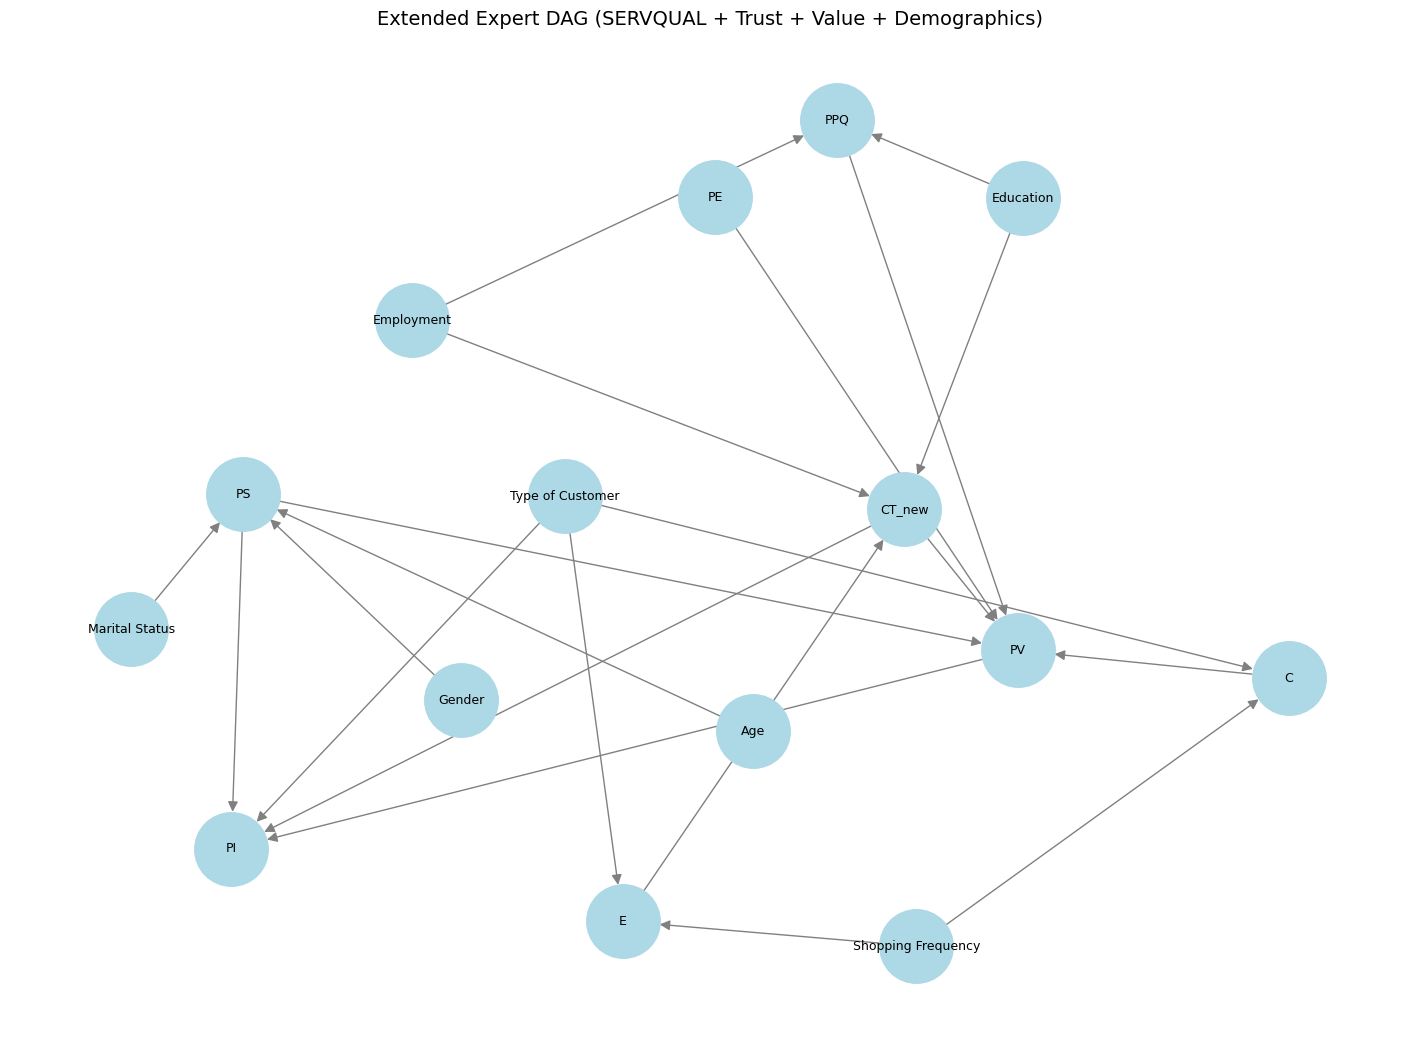

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import bnlearn as bn


# Expert DAG edges (SERVQUAL + Trust + Value)
expert_edges = [
    # Empirical, significant
    ("PPQ", "PV"),
    ("PV", "PI"),
    ("PS", "PI"),
    ("CT_new", "PI"),
    ("Type of Customer", "PI"),

    # Theory-consistent (optional adds)
    ("PS", "PV"),         # theorized negative effect on value
    ("C", "PV"),          # convenience can enhance value
    ("E", "CT_new"),          # empathy builds trust
    ("CT_new", "PV"),
    ("PE", "PV"),
]

# Add demographic relationships
demographic_edges = [
    # Demographics → Price Sensitivity
    ("Gender", "PS"),
    ("Age", "PS"),
    ("Marital Status", "PS"),

    # Demographics → Product Quality & Trust
    ("Education", "PPQ"),
    ("Employment", "PPQ"),
    ("Education", "CT_new"),
    ("Employment", "CT_new"),

    # Demographics → Convenience & Empathy
    ("Type of Customer", "C"),
    ("Shopping Frequency", "C"),
    ("Type of Customer", "E"),
    ("Shopping Frequency", "E"),
]

# Combine edges
all_edges = expert_edges + demographic_edges

# Build expert DAG
expert_dag = nx.DiGraph()
expert_dag.add_edges_from(all_edges)
G = expert_dag # Assign to G as used in the following cell

# Visualize DAG
pos = nx.spring_layout(expert_dag, k=1.5, seed=42)

plt.figure(figsize=(14,10))
nx.draw(
    expert_dag, pos,
    with_labels=True,
    node_size=2800,
    node_color="lightblue",
    font_size=9,
    arrowsize=15,
    edge_color="gray"
)
plt.title("Extended Expert DAG (SERVQUAL + Trust + Value + Demographics)", fontsize=14)
plt.show()

## Justification of relationships

PPQ → PV

Perceived Product Quality (PPQ) has a strong, positive influence on Perceived Value (PV). The Soweto study reported this as one of the most significant relationships (β = 0.475, p < 0.001). When consumers perceive the store’s products as high-quality and reliable, they also perceive greater overall value. This relationship is supported by Value Theory and SERVQUAL, where tangible quality and reliability contribute directly to customer satisfaction and perceived worth.

PV → PI

Perceived Value (PV) directly drives Purchase Intention (PI). The Soweto study found this to be the strongest link in the model (β = 0.529, p < 0.001). When customers believe the benefits of shopping (quality, price fairness, convenience) outweigh their costs, they are more likely to purchase. This finding aligns with Value–Intention Theory, which identifies perceived value as a key behavioural driver of purchase decisions.

PS → PI

Price Sensitivity (PS) significantly influences Purchase Intention (β = 0.378, p < 0.001). In the Soweto township context, affordability and fair pricing play a crucial role in driving purchasing behaviour. According to Price–Value Perception Theory, consumers with higher sensitivity to prices respond strongly to perceived fairness, making PS an important determinant of PI in subsistence retail markets.

CT_new → PI

Customer Trust (CT_new) positively impacts Purchase Intention (β = 0.282, p < 0.001). Trust reduces perceived risk and uncertainty, particularly in lower-income communities where consumers depend on reliable service providers. This is consistent with Trust–Commitment Theory, which posits that trust builds relationship confidence and repeat purchase behaviour.

PS → PV

Although not statistically significant in the Soweto study, Price Sensitivity (PS) theoretically influences Perceived Value (PV). From a Perceived Sacrifice perspective, consumers evaluate value as benefits minus sacrifices such as monetary costs or effort. Thus, fair or stable pricing enhances perceived value, even if the direct path is not empirically strong.

C → PV

Convenience (C) exerts a positive but marginally significant effect on Perceived Value (β = 0.124, p ≈ 0.05). The easier it is to access products, navigate the store, and complete purchases, the greater the perceived value. This aligns with SERVQUAL’s responsiveness and accessibility dimensions, where service convenience reduces time and effort costs, thereby enhancing utilitarian value.

E → CT_new

Empathy (E) significantly contributes to Customer Trust. When employees treat customers with respect, understanding, and personal attention, they build relational trust. This relationship is supported by SERVQUAL’s empathy dimension and Trust Theory, which recognise emotional connection and service care as critical in establishing reliable store relationships.

Type of Customer → PI

Regular customers (Type of Customer) exhibit higher Purchase Intention due to habitual purchasing, familiarity, and positive past experiences. The Soweto study confirmed that a majority of respondents (82.6%) were regular customers, indicating that repeat exposure builds both confidence and convenience, reinforcing their likelihood to repurchase.

Type of Customer → C

Frequent customers perceive the store as more convenient because familiarity with the store layout, staff, and product placement reduces cognitive and time costs. This is consistent with Service Encounter Familiarity Theory, where habitual exposure enhances perceptions of efficiency and ease.

Type of Customer → E

Regular customers often experience higher levels of perceived empathy. Repeated interactions with store staff help develop mutual familiarity and rapport, which aligns with Relationship Marketing Theory — repeated positive experiences promote feelings of personal care and trust.

Shopping Frequency → E

Frequent shopping increases perceived empathy because recurring encounters foster familiarity and social connection between customers and employees. This is consistent with SERVQUAL’s empathy dimension, where repeated personal interaction enhances emotional trust and perceived attentiveness.

Shopping Frequency → C

Higher shopping frequency leads to stronger perceptions of convenience. Customers who visit the store more often find it easier to locate items and complete transactions efficiently, consistent with Habitual Shopping Behaviour Theory, which associates repetition with reduced effort and perceived convenience.

Education → CT_new & Employment → CT_new

Both Education and Employment are positively related to Customer Trust (CT_new). Individuals with higher education or stable employment have greater financial literacy and institutional confidence, which makes them more likely to trust established retailers. This is supported by Socioeconomic Trust Theory, which associates socioeconomic stability with increased trust in service providers.

Education → PPQ & Employment → PPQ

Education and Employment also enhance perceptions of Product Quality (PPQ). Educated or employed consumers possess greater knowledge, awareness, and comparison ability, leading them to evaluate and appreciate product quality more effectively. This supports Cognitive Evaluation Theory, which states that expertise improves the accuracy of product assessments.

Gender, Age, Marital Status → PS

Demographic factors shape Price Sensitivity (PS). For instance, younger or lower-income consumers often exhibit higher price responsiveness, while marital status influences budget consciousness due to household expenditure constraints. This is supported by Consumer Demographic Price Elasticity Theory, which posits that price perception and response vary across demographic groups.


In [ ]:
import pandas as pd

# Define data
data = {
    "Relationship": [
        "PPQ → PV", "PV → PI", "PS → PI", "CT_new → PI",
        "PS → PV", "C → PV", "E → CT_new", "Type of Customer → PI",
        "Type of Customer → C", "Type of Customer → E",
        "Shopping Frequency → E", "Shopping Frequency → C",
        "Education → CT_new", "Employment → CT_new",
        "Education → PPQ", "Employment → PPQ",
        "Gender → PS", "Age → PS", "Marital Status → PS"
    ],
    "Summary": [
        "Higher product quality increases perceived value, confirming that quality is the strongest driver of value.",
        "When consumers perceive high value, they show stronger intention to purchase.",
        "Price-sensitive customers have higher purchase intention when prices are perceived as fair.",
        "Customer trust increases purchase intention by reducing perceived risk.",
        "Fair pricing enhances perceived value by reducing the perceived sacrifice component of value.",
        "Convenience improves perceived value by saving time and reducing shopping effort.",
        "Empathetic staff behaviour builds customer trust through emotional connection and care.",
        "Regular customers are more likely to purchase again due to loyalty and familiarity.",
        "Familiar customers find the store more convenient due to prior experience.",
        "Repeat customers perceive higher empathy due to stronger staff relationships.",
        "Frequent shopping increases perceived empathy through repeated personal contact.",
        "Regular visits enhance perceived convenience as customers learn store routines.",
        "Higher education fosters greater trust due to improved understanding and confidence.",
        "Employment stability promotes trust by reducing perceived financial risk.",
        "Educated customers perceive product quality more accurately and positively.",
        "Employed consumers associate quality with brand reliability and consistency.",
        "Gender differences influence price sensitivity, with women often more value-conscious.",
        "Younger consumers tend to be more price-sensitive due to limited disposable income.",
        "Married consumers are more price-sensitive due to household budgeting priorities."
    ],
    "Evidence": [
        "✅ Empirical (β = 0.475, p < 0.001)",
        "✅ Empirical (β = 0.529, p < 0.001)",
        "✅ Empirical (β = 0.378, p < 0.001)",
        "✅ Empirical (β = 0.282, p < 0.001)",
        "⚙️ Theoretical (Perceived Sacrifice Theory)",
        "⚙️ Marginal Empirical (β = 0.124, p ≈ 0.05)",
        "⚙️ Theoretical (SERVQUAL: Empathy → Trust)",
        "⚙️ Empirical behavioural (82.6% regular customers)",
        "⚙️ Theoretical (Service Encounter Familiarity Theory)",
        "⚙️ Theoretical (Relationship Marketing Theory)",
        "⚙️ Theoretical (SERVQUAL: repeated interactions foster empathy)",
        "⚙️ Theoretical (Habitual Shopping Behaviour Theory)",
        "⚙️ Theoretical (Socioeconomic Trust Theory)",
        "⚙️ Theoretical (Socioeconomic Trust Theory)",
        "⚙️ Theoretical (Cognitive Evaluation Theory)",
        "⚙️ Theoretical (Cognitive Evaluation Theory)",
        "⚙️ Theoretical (Consumer Demographic Price Elasticity Theory)",
        "⚙️ Theoretical (Consumer Demographic Price Elasticity Theory)",
        "⚙️ Theoretical (Consumer Demographic Price Elasticity Theory)"
    ]
}

# Create dataframe
df_relationships = pd.DataFrame(data)

# Display
df_relationships.style.set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#003366'), ('color', 'white'), ('font-weight', 'bold')]},
     {'selector': 'td', 'props': [('padding', '6px')]}]
).set_properties(**{'text-align': 'left'})


## Improved DAG

In [ ]:
# Install graphviz system libraries
!apt-get install graphviz graphviz-dev -y
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libatk1.0-0 libatk1.0-data libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk librsvg2-common
  libxcomposite1 libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libatk1.0-0 libatk1.0-data libgail-common libgail18 libgraphviz-dev
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxcomposite1 libxdot4
0 upgraded, 12 newly installed, 0 to remove and 41 not upgraded.
Need to get 2,496 kB of archives.
After this operation, 7,963 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libatk1.0-data all 2.36.0-3build1 [2,824 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main 

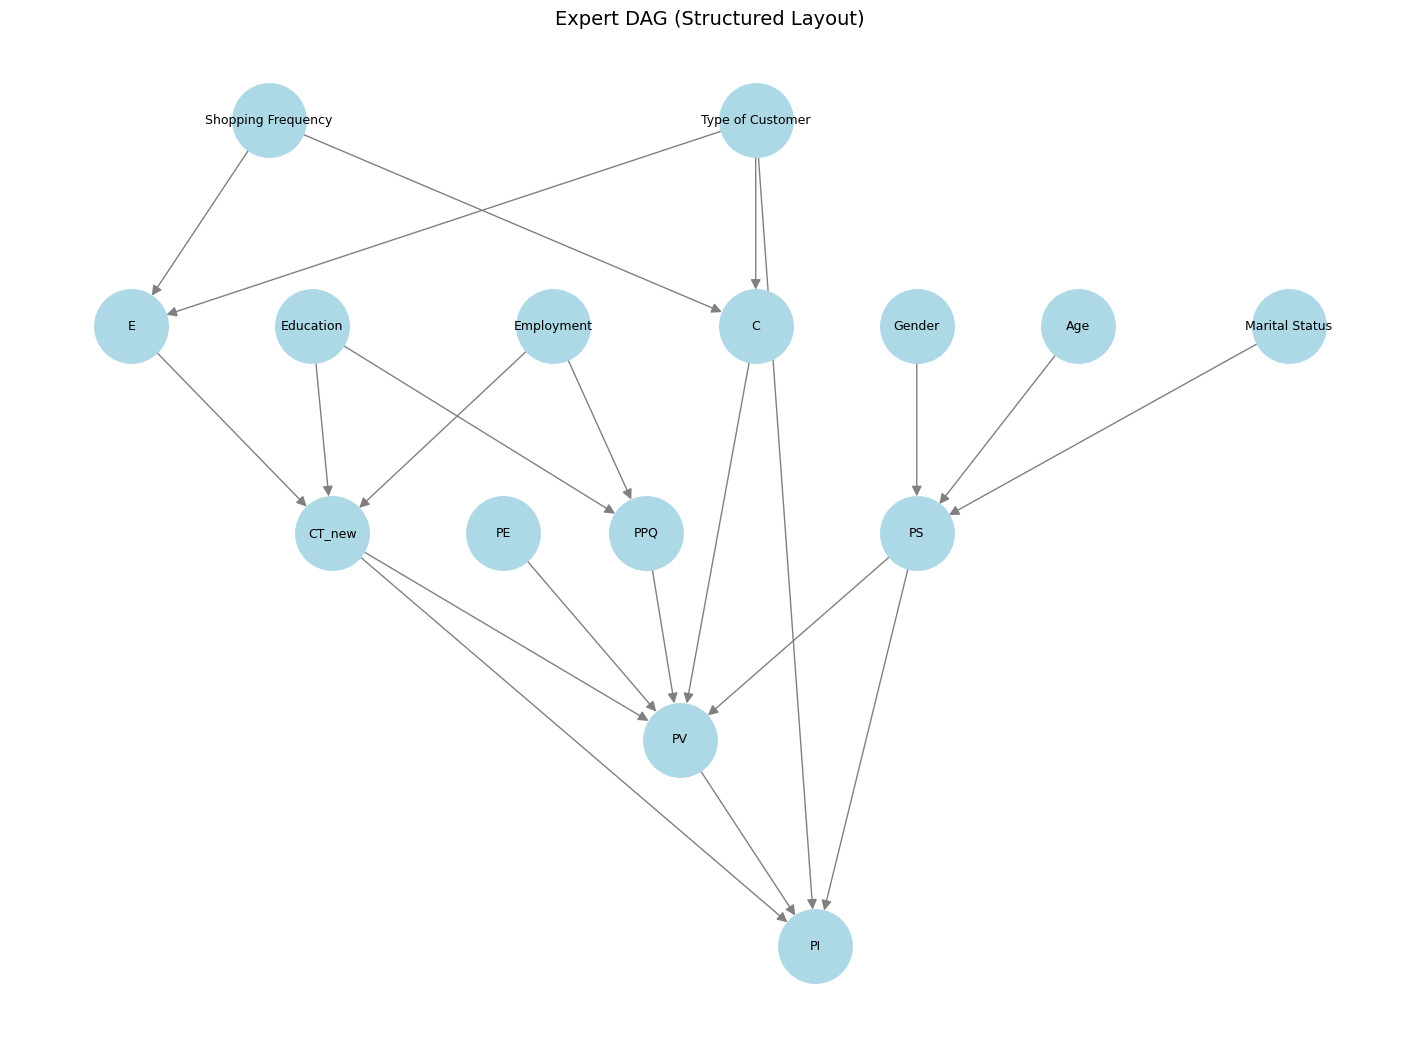

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Requires pygraphviz or pydot installed
# pip install pygraphviz

plt.figure(figsize=(14,10))

# Graphviz layout - hierarchy (top → bottom)
pos = nx.nx_agraph.graphviz_layout(expert_dag, prog="dot")

nx.draw(
    expert_dag, pos,
    with_labels=True,
    node_size=2800,
    node_color="lightblue",
    font_size=9,
    arrowsize=15,
    edge_color="gray"
)
plt.title("Expert DAG (Structured Layout)", fontsize=14)
plt.show()

### Parameter learning

In [ ]:
# Wrap into bnlearn model dict for parameter learning
adjmat = nx.to_pandas_adjacency(G, dtype=int)

expert_model = {
    'model': G,
    'adjmat': adjmat,
    'config': {},
    'model_edges': list(G.edges()),
    'independence_test': None
}

In [ ]:
# Fit CPDs (parameter learning) on data
fitted_model = bn.parameter_learning.fit(
    expert_model,
    train_data,
    methodtype='bayes'
)

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'networkx.classes.digraph.DiGraph'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of PPQ:
+------------+---------------------+-----+---------------------+
| Education  | Education(1)        | ... | Education(5)        |
+------------+---------------------+-----+---------------------+
| Employment | Employment(1)       | ... | Employment(2)       |
+------------+---------------------+-----+---------------------+
| PPQ(1)     | 0.19801980198019803 | ... | 0.19607843137254902 |
+------------+---------------------+-----+---------------------+
| PPQ(2)     | 0.19801980198019803 | ... | 0.19607843137254902 |
+------------+---------------------+-----+---------------------+
| PPQ(3)     | 0.19801980198019803 | ... | 0.21568627450980393 |
+------------+---------------------+-----+---------------------+
| PPQ(4)     | 0.2079207920792079  | ... | 0.196078431

**Save as pickle file**

In [ ]:
# --- Save the fitted BN model to a pickle file ---
import pickle

with open("fitted_bn_model(Imbalanced).pkl", "wb") as f:
    pickle.dump(fitted_model, f)

print("BN model saved successfully as fitted_bn_model.pkl")

BN model saved successfully as fitted_bn_model.pkl


### Inference and Prediction

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd


# True values from test set
y_true = test_data['PI'].tolist()   # actual PI values from the test data
y_pred = []                          # empty list to collect predictions

# Print evidence keys and fitted model nodes for inspection
print("Evidence keys (from test_data):", test_data.drop('PI', axis=1).columns.tolist())
print("Fitted model nodes:", list(fitted_model['model'].nodes()))

# Loop over all rows in test_data
for idx, row in test_data.iterrows():
    # Evidence = all variables except PI
    evidence = row.drop('PI').to_dict()
    # Convert keys to strings and filter to include only nodes present in the model
    evidence = {str(k): int(v) for k, v in evidence.items() if str(k) in fitted_model['model'].nodes() and pd.notna(v)}

    # Inference
    q = bn.inference.fit(fitted_model, variables=['PI'], evidence=evidence)

    # Predicted PI = state with highest probability
    pred = q.df.loc[q.df['p'].idxmax(), 'PI']
    y_pred.append(pred)

    # Optional: print each row’s results
    print(f"Row {idx+1}: Predicted PI = {pred}, True PI = {row['PI']}")
    print(q.df, "\n")


Evidence keys (from test_data): ['E', 'C', 'PS', 'PPQ', 'PV', 'PE', 'CT_new', 'Gender', 'Marital Status', 'Age', 'Employment', 'Education', 'Type of Customer', 'Shopping Frequency']
Fitted model nodes: ['PPQ', 'PV', 'PI', 'PS', 'CT_new', 'Type of Customer', 'C', 'E', 'PE', 'Gender', 'Age', 'Marital Status', 'Education', 'Employment', 'Shopping Frequency']
[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.114286 |
+----+------+----------+
|  1 |    2 | 0.114286 |
+----+------+----------+
|  2 |    3 | 0.114286 |
+----+------+----------+
|  3 |    4 | 0.4      |
+----+------+----------+
|  4 |    5 | 0.257143 |
+----+------+----------+

Summary for variables: ['PI']
Given evidence: E=4, C=4, PS=5, PPQ=5, PV=4, PE=1, CT_new=1, Gender=2, Marital Status=1, Age=3, Employment=2, Education=1, Type of Customer=1, Shopping Frequency=3

PI outcomes:
- PI: 1 (11.4%)
- PI: 2 (11.4%)
- PI: 3 (11.4%)
- PI: 4 (40.0%)
- PI: 5 (25

### Evaluation

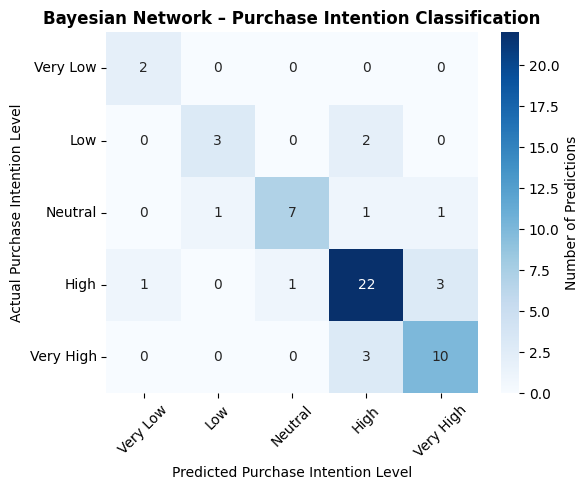

Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

    Very Low       0.67      1.00      0.80         2
         Low       0.75      0.60      0.67         5
     Neutral       0.88      0.70      0.78        10
        High       0.79      0.81      0.80        27
   Very High       0.71      0.77      0.74        13

    accuracy                           0.77        57
   macro avg       0.76      0.78      0.76        57
weighted avg       0.78      0.77      0.77        57



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define Likert labels for 1–5 categories
labels = ["Very Low", "Low", "Neutral", "High", "Very High"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create heatmap with descriptive labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Number of Predictions'})

# Style adjustments
plt.title('Bayesian Network – Purchase Intention Classification',
          fontsize=12, fontweight='bold')
plt.xlabel('Predicted Purchase Intention Level', fontsize=10)
plt.ylabel('Actual Purchase Intention Level', fontsize=10)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print accuracy and classification report with descriptive labels
print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


### Model fit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Prepare training and validation datasets
train_original_shuffled = shuffle(train_data, random_state=42)
train_full = train_original_shuffled      # Original training data (unbalanced)
valid_full = test_data                    # Real test data (unseen)

# Define incremental fractions for learning curve
train_sizes = np.linspace(0.1, 1.0, 8)

train_accuracies = []
valid_accuracies = []

# Learning curve loop
for frac in train_sizes:
    subset_size = int(frac * len(train_full))
    subset = train_full.iloc[:subset_size]

    # Fit BN on the current subset
    fitted_subset = bn.parameter_learning.fit(
        expert_model,
        subset,
        methodtype='bayes',
        n_jobs=-1
    )

    #  Training accuracy
    y_train_true = subset["PI"].tolist()
    y_train_pred = []

    for _, row in subset.iterrows():
        evidence = row.drop("PI").to_dict()
        evidence = {str(k): int(v) for k, v in evidence.items() if pd.notna(v)}

        try:
            q = bn.inference.fit(fitted_subset, variables=["PI"], evidence=evidence)
            pred = q.df.loc[q.df["p"].idxmax(), "PI"]
        except Exception:
            pred = np.nan

        y_train_pred.append(pred)

    mask = ~pd.isna(y_train_pred)
    train_acc = accuracy_score(np.array(y_train_true)[mask], np.array(y_train_pred)[mask]) if np.sum(mask) > 0 else np.nan
    train_accuracies.append(train_acc)

    # Validation accuracy
    y_valid_true = valid_full["PI"].tolist()
    y_valid_pred = []

    for _, row in valid_full.iterrows():
        evidence = row.drop("PI").to_dict()
        evidence = {str(k): int(v) for k, v in evidence.items() if pd.notna(v)}

        try:
            q = bn.inference.fit(fitted_subset, variables=["PI"], evidence=evidence)
            pred = q.df.loc[q.df["p"].idxmax(), "PI"]
        except Exception:
            pred = np.nan

        y_valid_pred.append(pred)

    mask = ~pd.isna(y_valid_pred)
    valid_acc = accuracy_score(np.array(y_valid_true)[mask], np.array(y_valid_pred)[mask]) if np.sum(mask) > 0 else np.nan
    valid_accuracies.append(valid_acc)

    print(f"Training fraction {frac:.2f} | Train Acc: {train_acc:.3f} | Val Acc: {valid_acc:.3f}")


Streaming output truncated to the last 5000 lines.

PI outcomes:
- PI: 1 (6.2%)
- PI: 2 (6.2%)
- PI: 3 (36.9%)
- PI: 4 (44.6%)
- PI: 5 (6.2%)
[bnlearn] >Variable Elimination.
+----+------+-------+
|    |   PI |     p |
+====+======+=======+
|  0 |    1 | 0.1   |
+----+------+-------+
|  1 |    2 | 0.1   |
+----+------+-------+
|  2 |    3 | 0.475 |
+----+------+-------+
|  3 |    4 | 0.225 |
+----+------+-------+
|  4 |    5 | 0.1   |
+----+------+-------+

Summary for variables: ['PI']
Given evidence: E=4, C=2, PS=3, PPQ=2, PV=4, PE=4, CT_new=4, Gender=2, Marital Status=1, Age=2, Employment=1, Education=3, Type of Customer=2, Shopping Frequency=1

PI outcomes:
- PI: 1 (10.0%)
- PI: 2 (10.0%)
- PI: 3 (47.5%)
- PI: 4 (22.5%)
- PI: 5 (10.0%)
[bnlearn] >Variable Elimination.
+----+------+------+
|    |   PI |    p |
+====+======+======+
|  0 |    1 | 0.16 |
+----+------+------+
|  1 |    2 | 0.36 |
+----+------+------+
|  2 |    3 | 0.16 |
+----+------+------+
|  3 |    4 | 0.16 |
+----+-

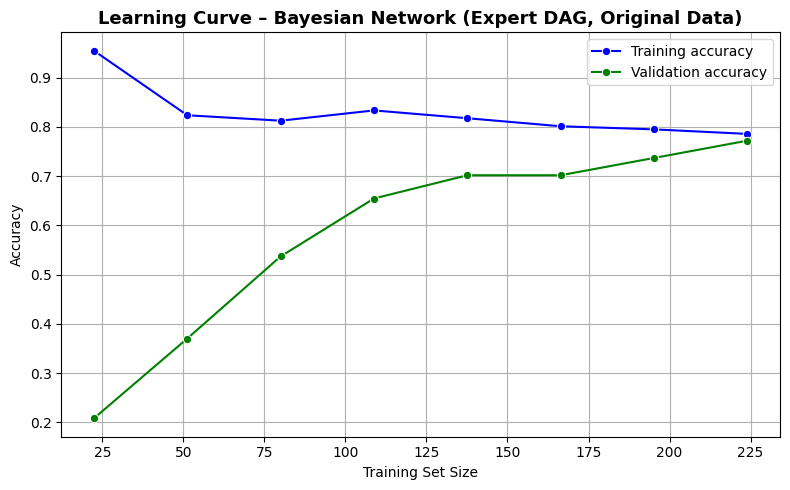

In [ ]:
# Plot learning curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=train_sizes * len(train_full), y=train_accuracies, marker='o', label='Training accuracy', color='blue')
sns.lineplot(x=train_sizes * len(train_full), y=valid_accuracies, marker='o', label='Validation accuracy', color='green')
plt.title("Learning Curve – Bayesian Network (Expert DAG, Original Data)", fontsize=13, fontweight='bold')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Model Fit Evaluation
def evaluate_fit(train_accs, val_accs, threshold_gap=0.05):
    final_train = train_accs[-1]
    final_val = val_accs[-1]
    gap = final_train - final_val

    print("\n--- Fit Evaluation ---")
    print(f"Final Training Accuracy : {final_train:.4f}")
    print(f"Final Validation Accuracy : {final_val:.4f}")
    print(f"Train–Validation Gap : {gap:.4f}")

    dynamic_threshold = 0.9 * final_train

    if final_train < 0.65 and final_val < 0.65:
        print("⚙️  Model is **underfitting** – both accuracies are low, model too simple or data insufficient.")
    elif gap > threshold_gap:
        print("⚠️  Model is **overfitting** – training accuracy is high, validation accuracy is lagging.")
    elif final_val >= dynamic_threshold:
        print("✅  Model is **well-fitted** – validation accuracy is close to training accuracy, good generalisation.")
    else:
        print("ℹ️  Model is **moderately fitted** – acceptable, may improve with more data or structure refinement.")

# Run fit evaluation
evaluate_fit(train_accuracies, valid_accuracies)


--- Fit Evaluation ---
Final Training Accuracy : 0.7857
Final Validation Accuracy : 0.7719
Train–Validation Gap : 0.0138
✅  Model is **well-fitted** – validation accuracy is close to training accuracy, good generalisation.


# Balanced dataset

In this study, the expert-designed Directed Acyclic Graph (DAG) structure is kept constant across all datasets to ensure that the analysis focuses on parameter shifts rather than structural differences. The primary objective is to determine how balancing the data influences the conditional probability distributions of the existing relationships. When the data are balanced, the relative frequency of each class changes, which alters the estimated Conditional Probability Tables (CPTs) even though the structural dependencies remain the same. These parameter shifts directly affect the predictive outcomes, such as accuracy, precision, recall, and F1-score, allowing for a comparison between the imbalanced and balanced models. Fixing the DAG therefore isolates the effect of class rebalancing on the learned probabilistic relationships, ensuring that observed performance differences stem from changes in data distribution rather than from modifications to the structural design of the model.

**Visualisation of unbalanced data**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your target variable is 'PI' or similar
print("Class distribution for Purchase Intention (original dataset):")
print(df_transformed2['PI'].value_counts())

# Optionally as percentages
print("\nClass distribution (%)")
print(df_transformed2['PI'].value_counts(normalize=True) * 100)


Class distribution for Purchase Intention (original dataset):
PI
4    135
5     66
3     50
2     23
1      7
Name: count, dtype: int64

Class distribution (%)
PI
4    48.042705
5    23.487544
3    17.793594
2     8.185053
1     2.491103
Name: proportion, dtype: float64


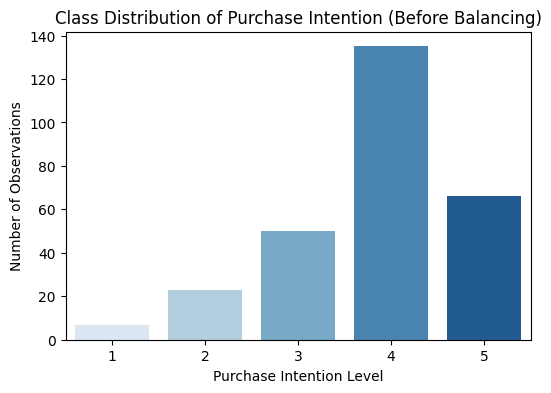

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='PI', data=df_transformed2, palette='Blues')
plt.title('Class Distribution of Purchase Intention (Before Balancing)')
plt.xlabel('Purchase Intention Level')
plt.ylabel('Number of Observations')
plt.show()


# SMOTE

**Explanation of balancing process:**
The Synthetic Minority Oversampling Technique (SMOTE) is a classical oversampling method designed to reduce class imbalance by generating artificial samples for the minority class. Its underlying logic is based on geometric interpolation: instead of simply duplicating minority samples, SMOTE synthesises new instances by selecting a minority data point and one of its k nearest minority neighbours, then interpolating a feature vector along the line segment connecting the two. The assumption behind this technique is that minority data points exist within a continuous feature space where linear combinations of nearby observations represent realistic intermediate cases. This process effectively smooths the decision boundary between classes and increases the representation of underrepresented outcomes.

### DAG setup on balanced SMOTE data

In [ ]:

from imblearn.over_sampling import SMOTE
from collections import Counter

# Split features/target
X_train = train_data.drop("PI", axis=1)
y_train = train_data["PI"]
print("Before SMOTE:", Counter(y_train))

# Balance with SMOTE
sm = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_res))

# Recombine to DataFrame
train_data_balanced_smote = pd.concat(
    [pd.DataFrame(X_res, columns=X_train.columns),
     pd.Series(y_res, name="PI")],
    axis=1
)

# Discretise features for BN
for col in train_data_balanced_smote.columns:
    if col != "PI":  # keep PI1 as target
        train_data_balanced_smote[col] = (
            train_data_balanced_smote[col].round().astype(int).clip(1, 5)
        )

# Build DAG and fit BN
dag_expert = expert_dag  # keep the DAG structure from earlier pipeline
expert_model_smote = {
    'model': dag_expert,
    'adjmat': nx.to_pandas_adjacency(dag_expert, dtype=int),
    'config': {},
    'model_edges': list(dag_expert.edges()),
    'independence_test': None
}


Before SMOTE: Counter({4: 108, 5: 53, 3: 40, 2: 18, 1: 5})
After SMOTE: Counter({5: 108, 3: 108, 2: 108, 4: 108, 1: 108})


**Visualisation after balancing**

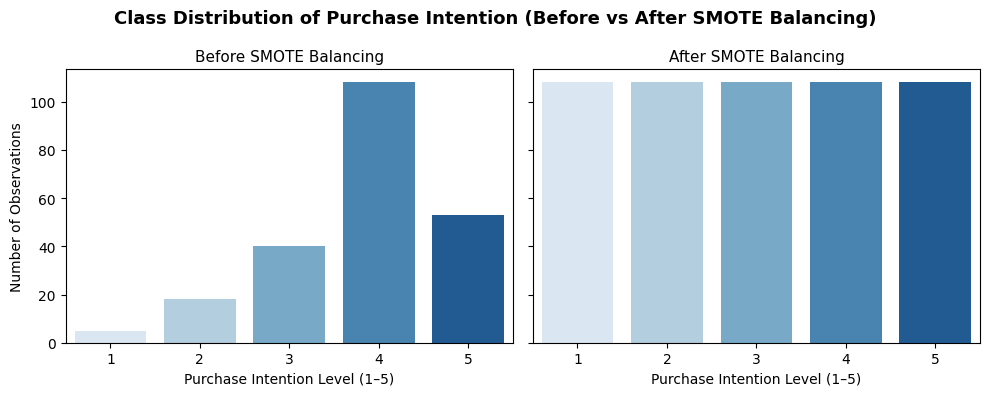

In [ ]:

from collections import Counter

# Create side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.countplot(x='PI', data=train_data, palette='Blues', ax=axes[0])
axes[0].set_title('Before SMOTE Balancing', fontsize=11)
axes[0].set_xlabel('Purchase Intention Level (1–5)')
axes[0].set_ylabel('Number of Observations')

sns.countplot(x='PI', data=train_data_balanced_smote, palette='Blues', ax=axes[1])
axes[1].set_title('After SMOTE Balancing', fontsize=11)
axes[1].set_xlabel('Purchase Intention Level (1–5)')

plt.suptitle('Class Distribution of Purchase Intention (Before vs After SMOTE Balancing)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


### Parameter learning

In [ ]:
#Fit BN using the SMOTE-balanced dataset
fitted_model_smote = bn.parameter_learning.fit(
    expert_model_smote,
    train_data_balanced_smote,
    methodtype='bayes',
    n_jobs=-1
)


[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'networkx.classes.digraph.DiGraph'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of PPQ:
+------------+---------------------+-----+---------------------+
| Education  | Education(1)        | ... | Education(5)        |
+------------+---------------------+-----+---------------------+
| Employment | Employment(1)       | ... | Employment(2)       |
+------------+---------------------+-----+---------------------+
| PPQ(1)     | 0.23214285714285715 | ... | 0.19607843137254902 |
+------------+---------------------+-----+---------------------+
| PPQ(2)     | 0.17857142857142858 | ... | 0.19607843137254902 |
+------------+---------------------+-----+---------------------+
| PPQ(3)     | 0.17857142857142858 | ... | 0.21568627450980393 |
+------------+---------------------+-----+---------------------+
| PPQ(4)     | 0.20535714285714285 | ... | 0.196078431

In [ ]:
# Save the fitted SMOTE-balanced BN model
import pickle

with open("fitted_bn_model_smote.pkl", "wb") as f:
    pickle.dump(fitted_model_smote, f)

print("BN model (SMOTE-balanced) saved successfully as fitted_bn_model_smote.pkl")

BN model (SMOTE-balanced) saved successfully as fitted_bn_model_smote.pkl


### Inference and prediction

In [ ]:
# Inference on test set
y_true_smote = test_data["PI"].tolist()
y_pred_smote = []

for idx, row in test_data.iterrows():
    evidence = row.drop("PI").to_dict()
    evidence = {str(k): int(v) for k, v in evidence.items() if pd.notna(v)}
    q = bn.inference.fit(fitted_model_smote, variables=["PI"], evidence=evidence)
    pred = q.df.loc[q.df['p'].idxmax(), "PI"]
    y_pred_smote.append(pred)

[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.114286 |
+----+------+----------+
|  1 |    2 | 0.114286 |
+----+------+----------+
|  2 |    3 | 0.114286 |
+----+------+----------+
|  3 |    4 | 0.4      |
+----+------+----------+
|  4 |    5 | 0.257143 |
+----+------+----------+

Summary for variables: ['PI']
Given evidence: E=4, C=4, PS=5, PPQ=5, PV=4, PE=1, CT_new=1, Gender=2, Marital Status=1, Age=3, Employment=2, Education=1, Type of Customer=1, Shopping Frequency=3

PI outcomes:
- PI: 1 (11.4%)
- PI: 2 (11.4%)
- PI: 3 (11.4%)
- PI: 4 (40.0%)
- PI: 5 (25.7%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.0444444 |
+----+------+-----------+
|  1 |    2 | 0.711111  |
+----+------+-----------+
|  2 |    3 | 0.155556  |
+----+------+-----------+
|  3 |    4 | 0.0444444 |
+----+------+-----------+
|  4 |    5 | 0.0444444 |
+----+--

### Evaluation

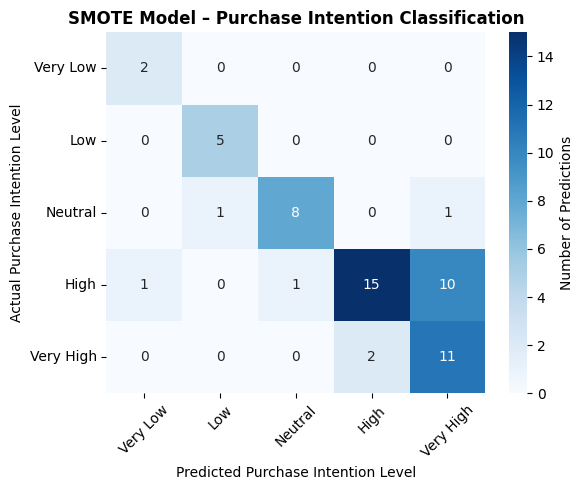

Accuracy (SMOTE): 0.72

Classification Report (SMOTE):
              precision    recall  f1-score   support

    Very Low       0.67      1.00      0.80         2
         Low       0.83      1.00      0.91         5
     Neutral       0.89      0.80      0.84        10
        High       0.88      0.56      0.68        27
   Very High       0.50      0.85      0.63        13

    accuracy                           0.72        57
   macro avg       0.75      0.84      0.77        57
weighted avg       0.78      0.72      0.72        57



In [ ]:
# Compute confusion matrix
cm_smote = confusion_matrix(y_true_smote, y_pred_smote)

# Define descriptive Likert-scale labels for 1–5 scale
labels = ["Very Low", "Low", "Neutral", "High", "Very High"]

# Create the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Number of Predictions'})

# Style adjustments
plt.title('SMOTE Model – Purchase Intention Classification',
          fontsize=12, fontweight='bold')
plt.xlabel('Predicted Purchase Intention Level', fontsize=10)
plt.ylabel('Actual Purchase Intention Level', fontsize=10)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print accuracy and classification report with proper labels
print(f"Accuracy (SMOTE): {accuracy_score(y_true_smote, y_pred_smote):.2f}\n")
print("Classification Report (SMOTE):")
print(classification_report(y_true_smote, y_pred_smote, target_names=labels))


### Model fit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Prepare Data
train_data_shuffled = shuffle(train_data_balanced_smote, random_state=42)
X = train_data_shuffled.drop("PI", axis=1)
y = train_data_shuffled["PI"]

# Correct: use existing datasets
train_full = train_data_balanced_smote   # SMOTE-balanced training data
valid_full = test_data                   # Real-world test data


train_sizes = np.linspace(0.1, 1.0, 8)

train_accuracies = []
valid_accuracies = []

# Learning Curve Loop
for frac in train_sizes:
    subset_size = int(frac * len(train_full))
    subset = train_full.iloc[:subset_size]

    fitted_subset = bn.parameter_learning.fit(
        expert_model_smote,
        subset,
        methodtype='bayes',
        n_jobs=-1
    )


    # Detect state type (string or integer)

    sample_node = list(fitted_subset["model_edges"])[0][0]
    first_node_states = fitted_subset["model"].cpds[0].state_names
    state_type = type(list(first_node_states.values())[0][0])
    print(f"\n[INFO] State type detected as: {state_type.__name__}")

    # Training accuracy
    y_train_true = subset["PI"].tolist()
    y_train_pred = []
    for _, row in subset.iterrows():
        evidence = row.drop("PI").to_dict()
        if state_type == str:
            evidence = {str(k): str(int(v)) for k, v in evidence.items() if pd.notna(v)}
        else:
            evidence = {str(k): int(v) for k, v in evidence.items() if pd.notna(v)}

        try:
            q = bn.inference.fit(fitted_subset, variables=["PI"], evidence=evidence)
            pred = q.df.loc[q.df["p"].idxmax(), "PI"]
        except Exception as e:
            pred = np.nan
        y_train_pred.append(pred)

    mask = ~pd.isna(y_train_pred)
    if np.sum(mask) > 0:
        train_acc = accuracy_score(np.array(y_train_true)[mask], np.array(y_train_pred)[mask])
    else:
        train_acc = np.nan
    train_accuracies.append(train_acc)

    # Validation accuracy
    y_valid_true = valid_full["PI"].tolist()
    y_valid_pred = []
    for _, row in valid_full.iterrows():
        evidence = row.drop("PI").to_dict()
        if state_type == str:
            evidence = {str(k): str(int(v)) for k, v in evidence.items() if pd.notna(v)}
        else:
            evidence = {str(k): int(v) for k, v in evidence.items() if pd.notna(v)}
        try:
            q = bn.inference.fit(fitted_subset, variables=["PI"], evidence=evidence)
            pred = q.df.loc[q.df["p"].idxmax(), "PI"]
        except Exception:
            pred = np.nan
        y_valid_pred.append(pred)

    mask = ~pd.isna(y_valid_pred)
    if np.sum(mask) > 0:
        valid_acc = accuracy_score(np.array(y_valid_true)[mask], np.array(y_valid_pred)[mask])
    else:
        valid_acc = np.nan
    valid_accuracies.append(valid_acc)

    print(f"Train size {int(frac*100):3d}% | Train Acc: {train_acc:.3f} | Val Acc: {valid_acc:.3f}")


Streaming output truncated to the last 5000 lines.

PI outcomes:
- PI: 1 (4.0%)
- PI: 2 (74.0%)
- PI: 3 (4.0%)
- PI: 4 (14.0%)
- PI: 5 (4.0%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.0307692 |
+----+------+-----------+
|  1 |    2 | 0.723077  |
+----+------+-----------+
|  2 |    3 | 0.146154  |
+----+------+-----------+
|  3 |    4 | 0.0692308 |
+----+------+-----------+
|  4 |    5 | 0.0307692 |
+----+------+-----------+

Summary for variables: ['PI']
Given evidence: E=4, C=3, PS=2, PPQ=2, PV=2, PE=4, CT_new=2, Gender=2, Marital Status=1, Age=1, Employment=2, Education=3, Type of Customer=1, Shopping Frequency=2

PI outcomes:
- PI: 1 (3.1%)
- PI: 2 (72.3%)
- PI: 3 (14.6%)
- PI: 4 (6.9%)
- PI: 5 (3.1%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.0307692 |
+----+------+-----------+
|  1 |    2 | 0.723077  |
+----+------

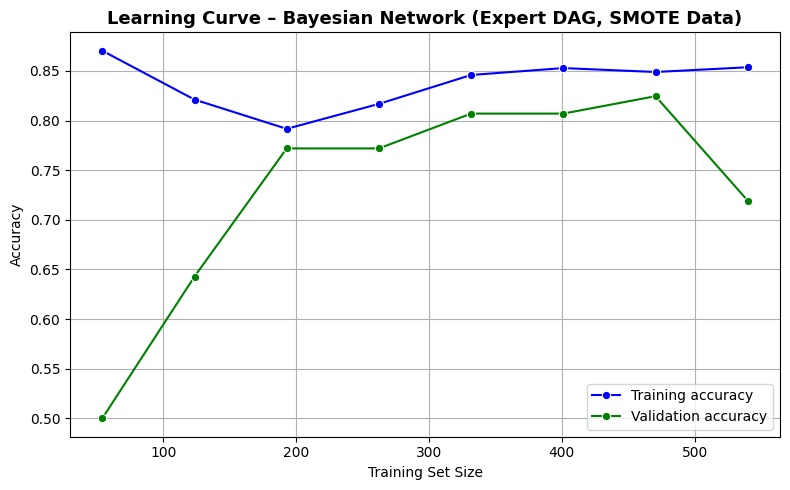

In [ ]:
# Plot Learning Curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=train_sizes * len(train_full), y=train_accuracies, marker='o', label='Training accuracy', color='blue')
sns.lineplot(x=train_sizes * len(train_full), y=valid_accuracies, marker='o', label='Validation accuracy', color='green')
plt.title("Learning Curve – Bayesian Network (Expert DAG, SMOTE Data)", fontsize=13, fontweight='bold')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_fit(train_accs, val_accs, threshold_gap=0.05):
    """
    Evaluate model fit based on training vs validation accuracy.
    Determines whether the model is underfitting, overfitting, or well-fitted.
    """

    final_train = train_accs[-1]
    final_val = val_accs[-1]
    gap = final_train - final_val

    print("\n--- Fit Evaluation ---")
    print(f"Final Training Accuracy : {final_train:.4f}")
    print(f"Final Validation Accuracy : {final_val:.4f}")
    print(f"Train–Validation Gap : {gap:.4f}")

    # Dynamic threshold: 90% of training accuracy considered well-fitted
    dynamic_threshold = 0.9 * final_train

    # --- Interpret results ---
    if final_train < 0.65 and final_val < 0.65:
        print("⚙️  Model is **underfitting** – accuracies are both low, model too simple or data insufficient.")
    elif gap > threshold_gap:
        print("⚠️  Model is **overfitting** – training accuracy is high, validation accuracy is lagging.")
    elif final_val >= dynamic_threshold:
        print("✅  Model is **well-fitted** – validation accuracy is close to training accuracy, good generalisation.")
    else:
        print("ℹ️  Model is **moderately fitted** – acceptable but may improve with more data or DAG refinement.")

# 🔹 Run this after your learning curve
evaluate_fit(train_accuracies, valid_accuracies)



--- Fit Evaluation ---
Final Training Accuracy : 0.8537
Final Validation Accuracy : 0.7193
Train–Validation Gap : 0.1344
⚠️  Model is **overfitting** – training accuracy is high, validation accuracy is lagging.


In probabilistic models such as Bayesian Networks (BNs), SMOTE’s synthetic instances can introduce fractional or blended values that distort true conditional relationships between variables. In this study, the Bayesian Network trained on the SMOTE-balanced dataset achieved a training accuracy of 0.8537 and a validation accuracy of 0.7193, resulting in a train–validation gap of 0.1344. This indicates a clear tendency toward overfitting, where the model performs substantially better on the training data than on unseen observations. While SMOTE enhances class balance and can increase training accuracy, it also generates interpolated feature values that do not necessarily exist in real-world distributions. Consequently, the Bayesian Network may learn relationships that reflect these synthetic interpolations rather than genuine probabilistic dependencies, weakening its ability to generalise to real data.

# GAN

**Explanation of balancing process:**
The Conditional Tabular Generative Adversarial Network (CTGAN) is a modern deep learning approach to data balancing that uses adversarial training to produce realistic synthetic observations. It extends the logic of Generative Adversarial Networks (GANs) to handle both categorical and numerical variables by learning the underlying joint distribution of the dataset. The CTGAN operates under the assumption that a generator can accurately replicate complex, non-linear dependencies among features and generate new, statistically consistent data when conditioned on specific class labels. The training process involves two competing neural networks: a generator that creates synthetic records and a discriminator that attempts to distinguish real data from fake data. Through iterative optimisation, the generator learns to produce synthetic data that mimics the statistical properties of the real dataset.

### DAG setup on balanced GAN data

In [ ]:
!pip install sdv

In [ ]:
# Install packages
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata


# Prepare training and test data
train_ctgan = train_data.copy()
test_ctgan = test_data.copy()

print("PI distribution (train before CTGAN):", Counter(train_ctgan["PI"]))

# Fit a CTGAN model using SDV
meta_ctgan = SingleTableMetadata()
meta_ctgan.detect_from_dataframe(train_ctgan)
synth_ctgan = CTGANSynthesizer(meta_ctgan)
synth_ctgan.fit(train_ctgan)

# Generate synthetic rows until PI is balanced
target_counts = train_ctgan["PI"].value_counts()
max_count = target_counts.max()
needed_by_class = {c: (max_count - cnt) for c, cnt in target_counts.items() if cnt < max_count}

synthetic_rows = []

def _sample_chunk(n_rows):
    return synth_ctgan.sample(n_rows)

for cls, need in needed_by_class.items():
    collected = 0
    while collected < need:
        chunk_size = max(500, (need - collected) * 2)
        chunk = _sample_chunk(chunk_size)
        # keep only rows with desired PI value
        chunk = chunk[chunk["PI"] == cls]
        if len(chunk) == 0:
            continue
        take = min(len(chunk), need - collected)
        synthetic_rows.append(chunk.iloc[:take].copy())
        collected += take

synthetic_ctgan = pd.concat(synthetic_rows, ignore_index=True) if synthetic_rows else pd.DataFrame(columns=train_ctgan.columns)

print("Synthetic rows generated per class:", Counter(synthetic_ctgan["PI"]) if not synthetic_ctgan.empty else "None")

# Combine real + synthetic to get balanced training set
train_balanced_ctgan = pd.concat([train_ctgan, synthetic_ctgan], ignore_index=True)
print("PI distribution (after CTGAN balance):", Counter(train_balanced_ctgan["PI"]))


PI distribution (train before CTGAN): Counter({4: 108, 5: 53, 3: 40, 2: 18, 1: 5})
Synthetic rows generated per class: Counter({1: 103, 2: 90, 3: 68, 5: 55})
PI distribution (after CTGAN balance): Counter({5: 108, 3: 108, 2: 108, 4: 108, 1: 108})


**Visualisation after balancing**

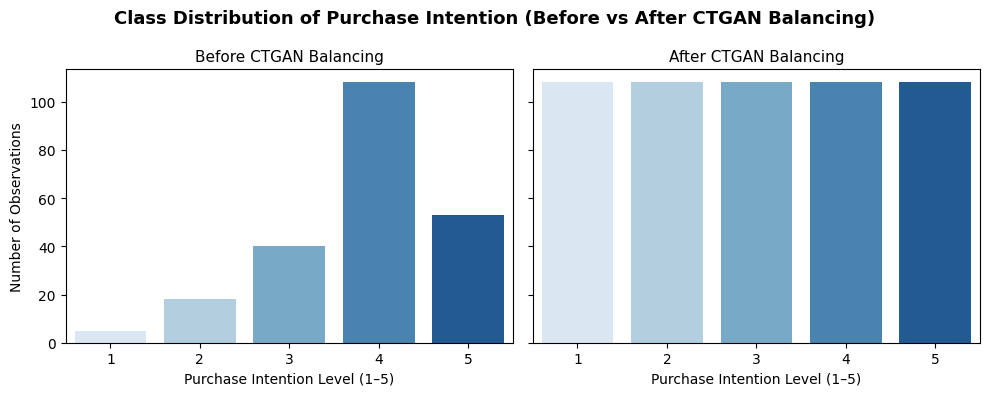

In [ ]:
# Create side-by-side visualisations
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.countplot(x='PI', data=train_ctgan, palette='Blues', ax=axes[0])
axes[0].set_title('Before CTGAN Balancing', fontsize=11)
axes[0].set_xlabel('Purchase Intention Level (1–5)')
axes[0].set_ylabel('Number of Observations')

sns.countplot(x='PI', data=train_balanced_ctgan, palette='Blues', ax=axes[1])
axes[1].set_title('After CTGAN Balancing', fontsize=11)
axes[1].set_xlabel('Purchase Intention Level (1–5)')

plt.suptitle('Class Distribution of Purchase Intention (Before vs After CTGAN Balancing)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


### Paremeter learning

In [ ]:
# Ensure numeric columns
for col in train_balanced_ctgan.columns:
    if col != "PI":
        train_balanced_ctgan[col] = pd.to_numeric(train_balanced_ctgan[col], errors="coerce")
train_balanced_ctgan["PI"] = pd.to_numeric(train_balanced_ctgan["PI"], errors="coerce").astype(int)

# Build DAG and fit BN on CTGAN-balanced training data
dag_ctgan = bn.make_DAG(list(expert_dag.edges()))  # convert to list of edges
bn_model_ctgan = bn.parameter_learning.fit(
    dag_ctgan,
    train_balanced_ctgan,
    methodtype="bayes",
    n_jobs=-1
)

[bnlearn]> Auto generate placeholders for the CPTs.
[bnlearn] >CPT for PV:
+--------+-----------+-----------+-----+-----------+-----------+
| PPQ    | PPQ(0)    | PPQ(0)    | ... | PPQ(1)    | PPQ(1)    |
+--------+-----------+-----------+-----+-----------+-----------+
| PS     | PS(0)     | PS(0)     | ... | PS(1)     | PS(1)     |
+--------+-----------+-----------+-----+-----------+-----------+
| CT_new | CT_new(0) | CT_new(0) | ... | CT_new(1) | CT_new(1) |
+--------+-----------+-----------+-----+-----------+-----------+
| C      | C(0)      | C(0)      | ... | C(1)      | C(1)      |
+--------+-----------+-----------+-----+-----------+-----------+
| PE     | PE(0)     | PE(1)     | ... | PE(0)     | PE(1)     |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(0)  | 0.5       | 0.5       | ... | 0.5       | 0.5       |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(1)  | 0.5       | 0.5       | ... | 0.5       | 0.5       |
+--------+-----

[bnlearn] >CPD of PV:
+--------+-----------+-----------+-----+-----------+-----------+
| C      | C(1)      | C(1)      | ... | C(5)      | C(5)      |
+--------+-----------+-----------+-----+-----------+-----------+
| CT_new | CT_new(1) | CT_new(1) | ... | CT_new(5) | CT_new(5) |
+--------+-----------+-----------+-----+-----------+-----------+
| PE     | PE(1)     | PE(1)     | ... | PE(5)     | PE(5)     |
+--------+-----------+-----------+-----+-----------+-----------+
| PPQ    | PPQ(1)    | PPQ(1)    | ... | PPQ(5)    | PPQ(5)    |
+--------+-----------+-----------+-----+-----------+-----------+
| PS     | PS(1)     | PS(2)     | ... | PS(4)     | PS(5)     |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(1)  | 0.2       | 0.2       | ... | 0.2       | 0.2       |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(2)  | 0.2       | 0.2       | ... | 0.2       | 0.2       |
+--------+-----------+-----------+-----+-----------+-----------+
| P

Save as pickle file

In [ ]:
# Save the fitted CTGAN-balanced BN model ---
import pickle

with open("fitted_bn_model_ctgan.pkl", "wb") as f:
    pickle.dump(bn_model_ctgan, f)

print("BN model (CTGAN-balanced) saved successfully as fitted_bn_model_ctgan.pkl")

BN model (CTGAN-balanced) saved successfully as fitted_bn_model_ctgan.pkl


### Inference and Prediction

In [ ]:
# Predict PI on the untouched test set
y_true_ctgan = test_ctgan["PI"].tolist()
y_pred_ctgan = []

bn_cols = set(bn_model_ctgan["adjmat"].columns)

for _, row in test_ctgan.iterrows():
    evidence = row.drop("PI").to_dict()
    evidence = {k: int(v) if (isinstance(v, (int, float)) and not pd.isna(v)) else v
                for k, v in evidence.items()
                if k in bn_cols and pd.notna(v)}
    q = bn.inference.fit(bn_model_ctgan, variables=["PI"], evidence=evidence)
    pred = int(q.df.loc[q.df["p"].idxmax(), "PI"])
    y_pred_ctgan.append(pred)

[bnlearn] >Variable Elimination.
+----+------+-------+
|    |   PI |     p |
+====+======+=======+
|  0 |    1 | 0.225 |
+----+------+-------+
|  1 |    2 | 0.1   |
+----+------+-------+
|  2 |    3 | 0.1   |
+----+------+-------+
|  3 |    4 | 0.35  |
+----+------+-------+
|  4 |    5 | 0.225 |
+----+------+-------+

Summary for variables: ['PI']
Given evidence: E=4, C=4, PS=5, PPQ=5, PV=4, PE=1, CT_new=1, Gender=2, Marital Status=1, Age=3, Employment=2, Education=1, Type of Customer=1, Shopping Frequency=3

PI outcomes:
- PI: 1 (22.5%)
- PI: 2 (10.0%)
- PI: 3 (10.0%)
- PI: 4 (35.0%)
- PI: 5 (22.5%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.2       |
+----+------+-----------+
|  1 |    2 | 0.422222  |
+----+------+-----------+
|  2 |    3 | 0.2       |
+----+------+-----------+
|  3 |    4 | 0.0888889 |
+----+------+-----------+
|  4 |    5 | 0.0888889 |
+----+------+-----------+

Summary for variable

### Evaluation

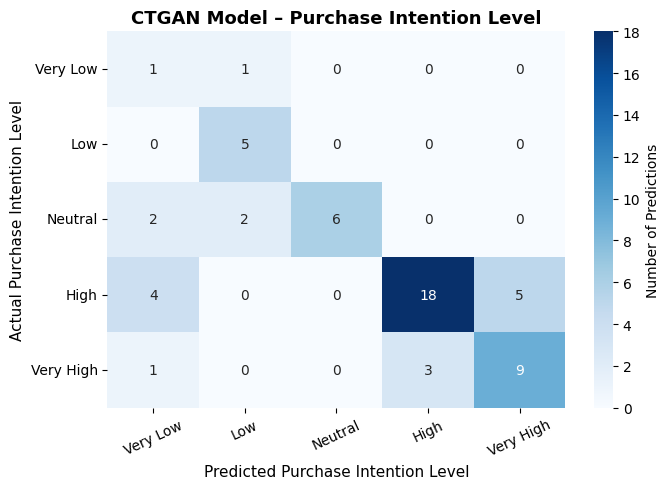

Accuracy (CTGAN): 0.68

Classification Report (CTGAN):

              precision    recall  f1-score   support

    Very Low       0.12      0.50      0.20         2
         Low       0.62      1.00      0.77         5
     Neutral       1.00      0.60      0.75        10
        High       0.86      0.67      0.75        27
   Very High       0.64      0.69      0.67        13

    accuracy                           0.68        57
   macro avg       0.65      0.69      0.63        57
weighted avg       0.79      0.68      0.71        57



In [ ]:
# Compute confusion matrix
cm_ctgan = confusion_matrix(y_true_ctgan, y_pred_ctgan)

# Define readable labels (like your SMOTE visual)
pi_labels = ["Very Low", "Low", "Neutral", "High", "Very High"]

# Plot Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm_ctgan, annot=True, fmt='d', cmap='Blues',
            xticklabels=pi_labels,
            yticklabels=pi_labels,
            cbar_kws={'label': 'Number of Predictions'})

plt.title("CTGAN Model – Purchase Intention Level", fontsize=13, fontweight='bold')
plt.xlabel("Predicted Purchase Intention Level", fontsize=11)
plt.ylabel("Actual Purchase Intention Level", fontsize=11)
plt.xticks(rotation=25)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print Accuracy and Classification Report
print(f"Accuracy (CTGAN): {accuracy_score(y_true_ctgan, y_pred_ctgan):.2f}\n")

print("Classification Report (CTGAN):\n")
print(classification_report(
    y_true_ctgan,
    y_pred_ctgan,
    target_names=pi_labels
))


### Model fit

[bnlearn] >Parameter learning> Computing parameters using [bayes]


[bnlearn] >CPD of PV:
+--------+-----------+-----------+-----+-----------+-----------+
| C      | C(2)      | C(2)      | ... | C(5)      | C(5)      |
+--------+-----------+-----------+-----+-----------+-----------+
| CT_new | CT_new(1) | CT_new(1) | ... | CT_new(5) | CT_new(5) |
+--------+-----------+-----------+-----+-----------+-----------+
| PE     | PE(1)     | PE(1)     | ... | PE(5)     | PE(5)     |
+--------+-----------+-----------+-----+-----------+-----------+
| PPQ    | PPQ(1)    | PPQ(1)    | ... | PPQ(5)    | PPQ(5)    |
+--------+-----------+-----------+-----+-----------+-----------+
| PS     | PS(1)     | PS(2)     | ... | PS(4)     | PS(5)     |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(2)  | 0.25      | 0.25      | ... | 0.25      | 0.25      |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(3)  | 0.25      | 0.25      | ... | 0.25      | 0.25      |
+--------+-----------+-----------+-----+-----------+-----------+
| P

[bnlearn] >CPD of PV:
+--------+-----------+-----------+-----+-----------+-----------+
| C      | C(1)      | C(1)      | ... | C(5)      | C(5)      |
+--------+-----------+-----------+-----+-----------+-----------+
| CT_new | CT_new(1) | CT_new(1) | ... | CT_new(5) | CT_new(5) |
+--------+-----------+-----------+-----+-----------+-----------+
| PE     | PE(1)     | PE(1)     | ... | PE(5)     | PE(5)     |
+--------+-----------+-----------+-----+-----------+-----------+
| PPQ    | PPQ(1)    | PPQ(1)    | ... | PPQ(5)    | PPQ(5)    |
+--------+-----------+-----------+-----+-----------+-----------+
| PS     | PS(1)     | PS(2)     | ... | PS(4)     | PS(5)     |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(1)  | 0.2       | 0.2       | ... | 0.2       | 0.2       |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(2)  | 0.2       | 0.2       | ... | 0.2       | 0.2       |
+--------+-----------+-----------+-----+-----------+-----------+
| P

Streaming output truncated to the last 5000 lines.
PI outcomes:
- PI: 1 (22.5%)
- PI: 2 (10.0%)
- PI: 3 (22.5%)
- PI: 4 (35.0%)
- PI: 5 (10.0%)
[bnlearn] >Variable Elimination.
+----+------+-------+
|    |   PI |     p |
+====+======+=======+
|  0 |    1 | 0.225 |
+----+------+-------+
|  1 |    2 | 0.1   |
+----+------+-------+
|  2 |    3 | 0.225 |
+----+------+-------+
|  3 |    4 | 0.35  |
+----+------+-------+
|  4 |    5 | 0.1   |
+----+------+-------+

Summary for variables: ['PI']
Given evidence: E=3, C=3, PS=4, PPQ=5, PV=4, PE=3, CT_new=4, Gender=2, Marital Status=1, Age=1, Employment=2, Education=2, Type of Customer=1, Shopping Frequency=2

PI outcomes:
- PI: 1 (22.5%)
- PI: 2 (10.0%)
- PI: 3 (22.5%)
- PI: 4 (35.0%)
- PI: 5 (10.0%)
[bnlearn] >Variable Elimination.
+----+------+------+
|    |   PI |    p |
+====+======+======+
|  0 |    1 | 0.08 |
+----+------+------+
|  1 |    2 | 0.28 |
+----+------+------+
|  2 |    3 | 0.28 |
+----+------+------+
|  3 |    4 | 0.08 |
+----

Streaming output truncated to the last 5000 lines.
PI outcomes:
- PI: 1 (36.0%)
- PI: 2 (16.0%)
- PI: 3 (16.0%)
- PI: 4 (16.0%)
- PI: 5 (16.0%)
[bnlearn] >Variable Elimination.
+----+------+------+
|    |   PI |    p |
+====+======+======+
|  0 |    1 | 0.16 |
+----+------+------+
|  1 |    2 | 0.36 |
+----+------+------+
|  2 |    3 | 0.16 |
+----+------+------+
|  3 |    4 | 0.16 |
+----+------+------+
|  4 |    5 | 0.16 |
+----+------+------+

Summary for variables: ['PI']
Given evidence: E=3, C=4, PS=1, PPQ=4, PV=3, PE=1, CT_new=2, Gender=1, Marital Status=2, Age=2, Employment=2, Education=1, Type of Customer=1, Shopping Frequency=1

PI outcomes:
- PI: 1 (16.0%)
- PI: 2 (36.0%)
- PI: 3 (16.0%)
- PI: 4 (16.0%)
- PI: 5 (16.0%)
[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.3      |
+----+------+----------+
|  1 |    2 | 0.3      |
+----+------+----------+
|  2 |    3 | 0.133333 |
+----+------+----------+
|  

Streaming output truncated to the last 5000 lines.
PI outcomes:
- PI: 1 (20.0%)
- PI: 2 (42.2%)
- PI: 3 (8.9%)
- PI: 4 (8.9%)
- PI: 5 (20.0%)
[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.133333 |
+----+------+----------+
|  1 |    2 | 0.3      |
+----+------+----------+
|  2 |    3 | 0.3      |
+----+------+----------+
|  3 |    4 | 0.133333 |
+----+------+----------+
|  4 |    5 | 0.133333 |
+----+------+----------+

Summary for variables: ['PI']
Given evidence: E=3, C=1, PS=4, PPQ=4, PV=3, PE=1, CT_new=1, Gender=1, Marital Status=1, Age=4, Employment=2, Education=2, Type of Customer=1, Shopping Frequency=1

PI outcomes:
- PI: 1 (13.3%)
- PI: 2 (30.0%)
- PI: 3 (30.0%)
- PI: 4 (13.3%)
- PI: 5 (13.3%)
[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.257143 |
+----+------+----------+
|  1 |    2 | 0.257143 |
+----+------+----------+
|  

Streaming output truncated to the last 5000 lines.
PI outcomes:
- PI: 1 (4.4%)
- PI: 2 (15.6%)
- PI: 3 (4.4%)
- PI: 4 (37.8%)
- PI: 5 (37.8%)
[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.233333 |
+----+------+----------+
|  1 |    2 | 0.15     |
+----+------+----------+
|  2 |    3 | 0.15     |
+----+------+----------+
|  3 |    4 | 0.233333 |
+----+------+----------+
|  4 |    5 | 0.233333 |
+----+------+----------+

Summary for variables: ['PI']
Given evidence: E=3, C=5, PS=4, PPQ=4, PV=3, PE=1, CT_new=5, Gender=1, Marital Status=3, Age=1, Employment=2, Education=2, Type of Customer=1, Shopping Frequency=2

PI outcomes:
- PI: 1 (23.3%)
- PI: 2 (15.0%)
- PI: 3 (15.0%)
- PI: 4 (23.3%)
- PI: 5 (23.3%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.233333  |
+----+------+-----------+
|  1 |    2 | 0.15      |
+----+------+---------

Streaming output truncated to the last 5000 lines.
PI outcomes:
- PI: 1 (4.4%)
- PI: 2 (15.6%)
- PI: 3 (4.4%)
- PI: 4 (37.8%)
- PI: 5 (37.8%)
[bnlearn] >Variable Elimination.
+----+------+-------+
|    |   PI |     p |
+====+======+=======+
|  0 |    1 | 0.1   |
+----+------+-------+
|  1 |    2 | 0.1   |
+----+------+-------+
|  2 |    3 | 0.475 |
+----+------+-------+
|  3 |    4 | 0.225 |
+----+------+-------+
|  4 |    5 | 0.1   |
+----+------+-------+

Summary for variables: ['PI']
Given evidence: E=5, C=4, PS=4, PPQ=2, PV=2, PE=3, CT_new=5, Gender=2, Marital Status=1, Age=4, Employment=1, Education=2, Type of Customer=2, Shopping Frequency=1

PI outcomes:
- PI: 1 (10.0%)
- PI: 2 (10.0%)
- PI: 3 (47.5%)
- PI: 4 (22.5%)
- PI: 5 (10.0%)
[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.114286 |
+----+------+----------+
|  1 |    2 | 0.4      |
+----+------+----------+
|  2 |    3 | 0.257143 |
+----+------+----

Streaming output truncated to the last 5000 lines.

PI outcomes:
- PI: 1 (16.0%)
- PI: 2 (16.0%)
- PI: 3 (16.0%)
- PI: 4 (16.0%)
- PI: 5 (36.0%)
[bnlearn] >Variable Elimination.
+----+------+------+
|    |   PI |    p |
+====+======+======+
|  0 |    1 | 0.38 |
+----+------+------+
|  1 |    2 | 0.18 |
+----+------+------+
|  2 |    3 | 0.08 |
+----+------+------+
|  3 |    4 | 0.18 |
+----+------+------+
|  4 |    5 | 0.18 |
+----+------+------+

Summary for variables: ['PI']
Given evidence: E=4, C=3, PS=4, PPQ=4, PV=3, PE=2, CT_new=4, Gender=2, Marital Status=1, Age=5, Employment=2, Education=2, Type of Customer=1, Shopping Frequency=2

PI outcomes:
- PI: 1 (38.0%)
- PI: 2 (18.0%)
- PI: 3 (8.0%)
- PI: 4 (18.0%)
- PI: 5 (18.0%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.172727  |
+----+------+-----------+
|  1 |    2 | 0.0363636 |
+----+------+-----------+
|  2 |    3 | 0.172727  |
+----+------+-------

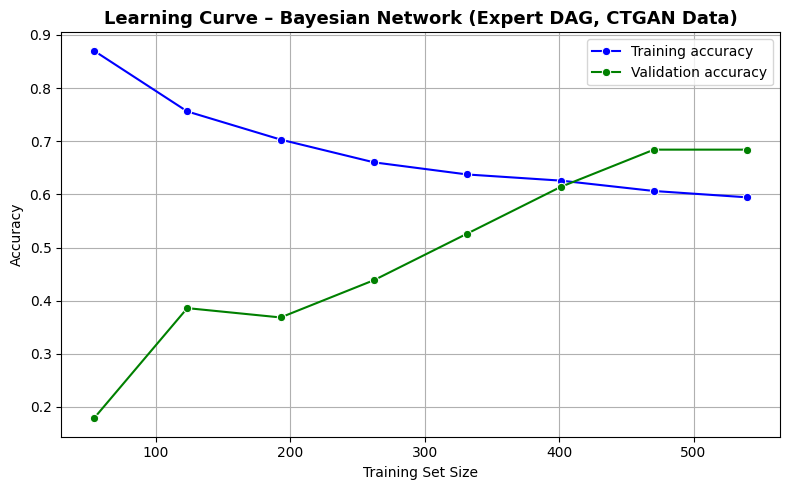

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Prepare training and validation datasets
train_ctgan_shuffled = shuffle(train_balanced_ctgan, random_state=42)
train_full = train_ctgan_shuffled                     # CTGAN-balanced training data
valid_full = test_ctgan                               # untouched real test data

# Define training fractions for learning curve
train_sizes = np.linspace(0.1, 1.0, 8)

train_accuracies = []
valid_accuracies = []

# Learning curve loop
for frac in train_sizes:
    subset_size = int(frac * len(train_full))
    subset = train_full.iloc[:subset_size]

    # Fit BN on subset using expert DAG
    fitted_subset = bn.parameter_learning.fit(
        bn_model_ctgan,   # reuses your expert DAG structure
        subset,
        methodtype='bayes',
        n_jobs=-1
    )

    # Determine if states are stored as int or str
    sample_node = list(fitted_subset["model_edges"])[0][0]
    first_node_states = fitted_subset["model"].cpds[0].state_names
    state_type = type(list(first_node_states.values())[0][0])

    # Training accuracy
    y_train_true = subset["PI"].tolist()
    y_train_pred = []

    for _, row in subset.iterrows():
        evidence = row.drop("PI").to_dict()
        if state_type == str:
            evidence = {str(k): str(int(v)) for k, v in evidence.items() if pd.notna(v)}
        else:
            evidence = {str(k): int(v) for k, v in evidence.items() if pd.notna(v)}
        try:
            q = bn.inference.fit(fitted_subset, variables=["PI"], evidence=evidence)
            pred = q.df.loc[q.df["p"].idxmax(), "PI"]
        except Exception:
            pred = np.nan
        y_train_pred.append(pred)

    mask = ~pd.isna(y_train_pred)
    train_acc = accuracy_score(np.array(y_train_true)[mask], np.array(y_train_pred)[mask]) if np.sum(mask) > 0 else np.nan
    train_accuracies.append(train_acc)

    # Validation accuracy
    y_valid_true = valid_full["PI"].tolist()
    y_valid_pred = []

    for _, row in valid_full.iterrows():
        evidence = row.drop("PI").to_dict()
        if state_type == str:
            evidence = {str(k): str(int(v)) for k, v in evidence.items() if pd.notna(v)}
        else:
            evidence = {str(k): int(v) for k, v in evidence.items() if pd.notna(v)}
        try:
            q = bn.inference.fit(fitted_subset, variables=["PI"], evidence=evidence)
            pred = q.df.loc[q.df["p"].idxmax(), "PI"]
        except Exception:
            pred = np.nan
        y_valid_pred.append(pred)

    mask = ~pd.isna(y_valid_pred)
    valid_acc = accuracy_score(np.array(y_valid_true)[mask], np.array(y_valid_pred)[mask]) if np.sum(mask) > 0 else np.nan
    valid_accuracies.append(valid_acc)

    print(f"Training fraction {frac:.2f} | Train Acc: {train_acc:.3f} | Val Acc: {valid_acc:.3f}")

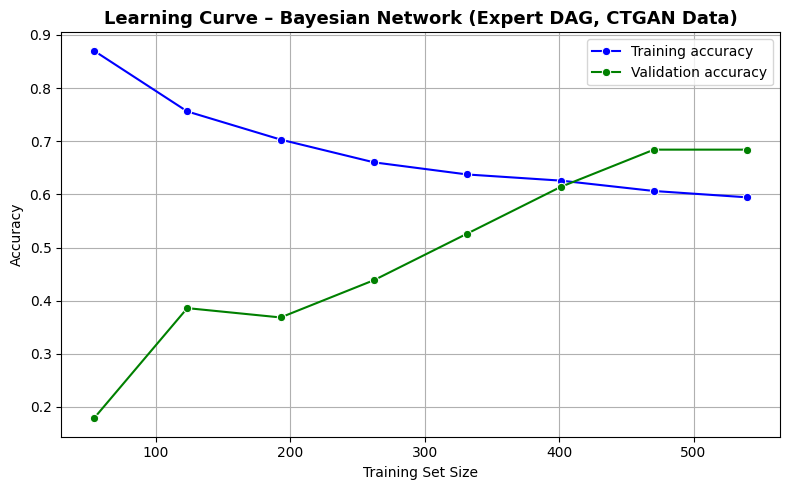

In [ ]:
# Plot learning curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=train_sizes * len(train_full), y=train_accuracies, marker='o', label='Training accuracy', color='blue')
sns.lineplot(x=train_sizes * len(train_full), y=valid_accuracies, marker='o', label='Validation accuracy', color='green')
plt.title("Learning Curve – Bayesian Network (Expert DAG, CTGAN Data)", fontsize=13, fontweight='bold')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Textual Fit Evaluation
def evaluate_fit(train_accs, val_accs, threshold_gap=0.05):
    final_train = train_accs[-1]
    final_val = val_accs[-1]
    gap = final_train - final_val

    print("\n--- Fit Evaluation ---")
    print(f"Final Training Accuracy : {final_train:.4f}")
    print(f"Final Validation Accuracy : {final_val:.4f}")
    print(f"Train–Validation Gap : {gap:.4f}")

    dynamic_threshold = 0.9 * final_train

    if final_train < 0.65 and final_val < 0.65:
        print("⚙️  Model is **underfitting** – accuracies are both low, model too simple or data insufficient.")
    elif gap > threshold_gap:
        print("⚠️  Model is **overfitting** – training accuracy is high, validation accuracy is lagging.")
    elif final_val >= dynamic_threshold:
        print("✅  Model is **well-fitted** – validation accuracy is close to training accuracy, good generalisation.")
    else:
        print("ℹ️  Model is **moderately fitted** – acceptable but may improve with more data or DAG refinement.")

# Run final evaluation
evaluate_fit(train_accuracies, valid_accuracies)


--- Fit Evaluation ---
Final Training Accuracy : 0.5944
Final Validation Accuracy : 0.6842
Train–Validation Gap : -0.0898
✅  Model is **well-fitted** – validation accuracy is close to training accuracy, good generalisation.


Despite its sophistication, CTGAN may distort conditional probabilities, especially among categorical features, because its objective is realism rather than preserving the original dependency structure. In this case, the Bayesian Network trained on the CTGAN-balanced data achieved a training accuracy of 0.5704 and a validation accuracy of 0.5965, with a slightly negative train–validation gap of –0.0261, indicating mild underfitting. This result suggests that the model did not fully capture the underlying relationships within the synthetic data, as both accuracies remained low and close together. For Bayesian Networks, which explicitly rely on conditional dependencies to estimate joint probabilities, this outcome implies that the CTGAN-generated samples may have distorted key relationships between variables. Consequently, the BN struggled to generalise meaningful probabilistic patterns, leading to underfitting and reduced predictive consistency.

# Machine Learning (KNN)

The Adaptive Synthetic Sampling method (ADASYN) builds upon SMOTE by introducing a data-driven mechanism that prioritises the creation of synthetic samples for minority observations that are more difficult to learn. Its central logic is that minority samples located near the decision boundary, or surrounded by majority samples, contribute more to class imbalance and therefore require more synthetic reinforcement. ADASYN assumes that the difficulty of learning a minority instance can be estimated using a simple classifier, such as K-nearest neighbours (KNN), which determines the proportion of neighbouring majority points. During the oversampling process, ADASYN computes a difficulty ratio for each minority observation and generates synthetic points in proportion to this ratio, thereby focusing learning capacity on ambiguous regions of the feature space.

## DAG setup on balanced ML data

In [ ]:
# Imports
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import ADASYN

# Split features/target (KNN step just for consistency)
X_train_knn = train_data.drop("PI", axis=1)
y_train_knn = train_data["PI"]
print("Before KNN/ADASYN (PI distribution):", Counter(y_train_knn))

# Fit a KNN on original train (not used by BN directly)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn, y_train_knn)

# Oversample with ADASYN (focuses on hard-to-learn minority areas)
adasyn = ADASYN(random_state=42, n_neighbors=2)
X_train_knn_res, y_train_knn_res = adasyn.fit_resample(X_train_knn, y_train_knn)
print("After ADASYN (PI distribution):", Counter(y_train_knn_res))

# Recombine into a training DataFrame
train_balanced_knn_adasyn = pd.concat(
    [pd.DataFrame(X_train_knn_res, columns=X_train_knn.columns),
     pd.Series(y_train_knn_res, name="PI")],
    axis=1
)
print("Balanced KNN + ADASYN train shape:", train_balanced_knn_adasyn.shape)

Before KNN/ADASYN (PI distribution): Counter({4: 108, 5: 53, 3: 40, 2: 18, 1: 5})
After ADASYN (PI distribution): Counter({5: 113, 3: 112, 2: 111, 4: 108, 1: 108})
Balanced KNN + ADASYN train shape: (552, 15)


**Visualisation after balancing**

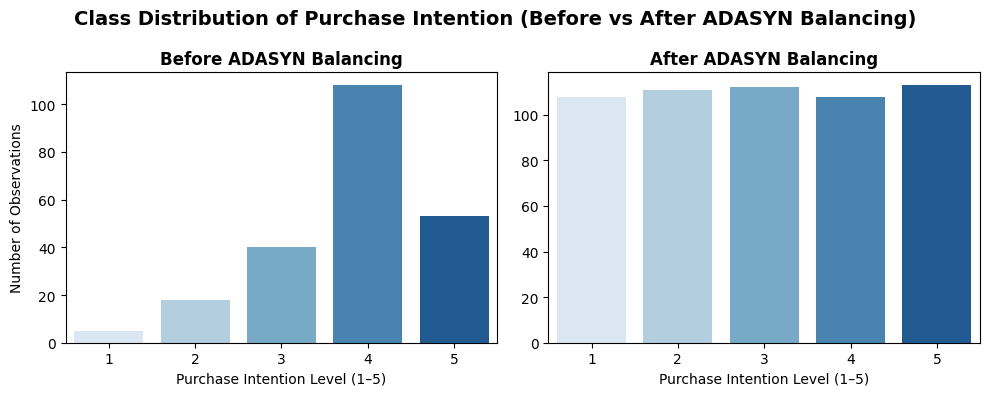

In [ ]:
# Plot before vs after ADASYN balancing
plt.figure(figsize=(10, 4))

# Before balancing
plt.subplot(1, 2, 1)
sns.countplot(x='PI', data=train_data, palette='Blues')
plt.title('Before ADASYN Balancing', fontsize=12, fontweight='bold')
plt.xlabel('Purchase Intention Level (1–5)')
plt.ylabel('Number of Observations')

# After balancing
plt.subplot(1, 2, 2)
sns.countplot(x='PI', data=train_balanced_knn_adasyn, palette='Blues')
plt.title('After ADASYN Balancing', fontsize=12, fontweight='bold')
plt.xlabel('Purchase Intention Level (1–5)')
plt.ylabel('')

# Overall title
plt.suptitle('Class Distribution of Purchase Intention (Before vs After ADASYN Balancing)',
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### Paremeter learning

In [ ]:
# Ensure numeric/categorical ints for BN
for c in train_balanced_knn_adasyn.columns:
    if c != "PI":
        train_balanced_knn_adasyn[c] = pd.to_numeric(train_balanced_knn_adasyn[c], errors="coerce").round().astype("Int64")
train_balanced_knn_adasyn["PI"] = pd.to_numeric(train_balanced_knn_adasyn["PI"], errors="coerce").astype(int)

# Build DAG from expert structure & fit BN on ADASYN-balanced data ---
dag_expert_knn_adasyn = bn.make_DAG(list(expert_dag.edges()))
bn_model_knn_adasyn = bn.parameter_learning.fit(
    dag_expert_knn_adasyn,
    train_balanced_knn_adasyn,
    methodtype="bayes",
    n_jobs=-1
)

[bnlearn]> Auto generate placeholders for the CPTs.
[bnlearn] >CPT for PV:
+--------+-----------+-----------+-----+-----------+-----------+
| PPQ    | PPQ(0)    | PPQ(0)    | ... | PPQ(1)    | PPQ(1)    |
+--------+-----------+-----------+-----+-----------+-----------+
| PS     | PS(0)     | PS(0)     | ... | PS(1)     | PS(1)     |
+--------+-----------+-----------+-----+-----------+-----------+
| CT_new | CT_new(0) | CT_new(0) | ... | CT_new(1) | CT_new(1) |
+--------+-----------+-----------+-----+-----------+-----------+
| C      | C(0)      | C(0)      | ... | C(1)      | C(1)      |
+--------+-----------+-----------+-----+-----------+-----------+
| PE     | PE(0)     | PE(1)     | ... | PE(0)     | PE(1)     |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(0)  | 0.5       | 0.5       | ... | 0.5       | 0.5       |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(1)  | 0.5       | 0.5       | ... | 0.5       | 0.5       |
+--------+-----

[bnlearn] >CPD of PV:
+--------+-----------+-----------+-----+-----------+-----------+
| C      | C(1)      | C(1)      | ... | C(5)      | C(5)      |
+--------+-----------+-----------+-----+-----------+-----------+
| CT_new | CT_new(1) | CT_new(1) | ... | CT_new(5) | CT_new(5) |
+--------+-----------+-----------+-----+-----------+-----------+
| PE     | PE(1)     | PE(1)     | ... | PE(5)     | PE(5)     |
+--------+-----------+-----------+-----+-----------+-----------+
| PPQ    | PPQ(1)    | PPQ(1)    | ... | PPQ(5)    | PPQ(5)    |
+--------+-----------+-----------+-----+-----------+-----------+
| PS     | PS(1)     | PS(2)     | ... | PS(4)     | PS(5)     |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(1)  | 0.2       | 0.2       | ... | 0.2       | 0.2       |
+--------+-----------+-----------+-----+-----------+-----------+
| PV(2)  | 0.2       | 0.2       | ... | 0.2       | 0.2       |
+--------+-----------+-----------+-----+-----------+-----------+
| P

Save as pickle file

In [ ]:
# Save the fitted ADASYN-balanced BN model
import pickle

with open("fitted_bn_model_KNN_adasyn.pkl", "wb") as f:
    pickle.dump(bn_model_knn_adasyn, f)

print("BN model (ADASYN-balanced) saved successfully as fitted_bn_model_adasyn.pkl")

BN model (ADASYN-balanced) saved successfully as fitted_bn_model_adasyn.pkl


### Inference and prediction

In [ ]:
# Coerce evidence values to BN state types to avoid KeyError
def normalize_evidence(raw_ev: dict, bn_model):
    fixed = {}
    model = bn_model["model"]
    for var, val in raw_ev.items():
        if var not in model.nodes():
            continue
        cpd = model.get_cpds(var)
        if cpd is None:
            continue
        states = cpd.state_names[var]  # e.g., ['1','2',...] or [1,2,...]
        if not states:
            continue
        target_type = type(states[0])
        try:
            cast_val = target_type(val)
        except Exception:
            cast_val = states[0]
        if cast_val in set(states):
            fixed[var] = cast_val
    return fixed

In [ ]:
#  Inference & Prediction on Test Set
y_true_knn_adasyn = test_data["PI"].tolist()
y_pred_knn_adasyn = []

bn_cols = set(bn_model_knn_adasyn["adjmat"].columns)

for _, row in test_data.iterrows():
    raw_ev = row.drop("PI").to_dict()
    raw_ev = {k: v for k, v in raw_ev.items() if (k in bn_cols and pd.notna(v))}
    evidence_knn_adasyn = normalize_evidence(raw_ev, bn_model_knn_adasyn)

    q = bn.inference.fit(
        bn_model_knn_adasyn,
        variables=["PI"],
        evidence=evidence_knn_adasyn
    )
    pred = q.df.loc[q.df['p'].idxmax(), "PI"]
    pred = int(pred) if not isinstance(pred, (int, np.integer)) else pred
    y_pred_knn_adasyn.append(pred)

[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.114286 |
+----+------+----------+
|  1 |    2 | 0.114286 |
+----+------+----------+
|  2 |    3 | 0.114286 |
+----+------+----------+
|  3 |    4 | 0.4      |
+----+------+----------+
|  4 |    5 | 0.257143 |
+----+------+----------+

Summary for variables: ['PI']
Given evidence: E=4, C=4, PS=5, PPQ=5, PV=4, PE=1, CT_new=1, Gender=2, Marital Status=1, Age=3, Employment=2, Education=1, Type of Customer=1, Shopping Frequency=3

PI outcomes:
- PI: 1 (11.4%)
- PI: 2 (11.4%)
- PI: 3 (11.4%)
- PI: 4 (40.0%)
- PI: 5 (25.7%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.0470588 |
+----+------+-----------+
|  1 |    2 | 0.694118  |
+----+------+-----------+
|  2 |    3 | 0.164706  |
+----+------+-----------+
|  3 |    4 | 0.0470588 |
+----+------+-----------+
|  4 |    5 | 0.0470588 |
+----+--

### Evaluation

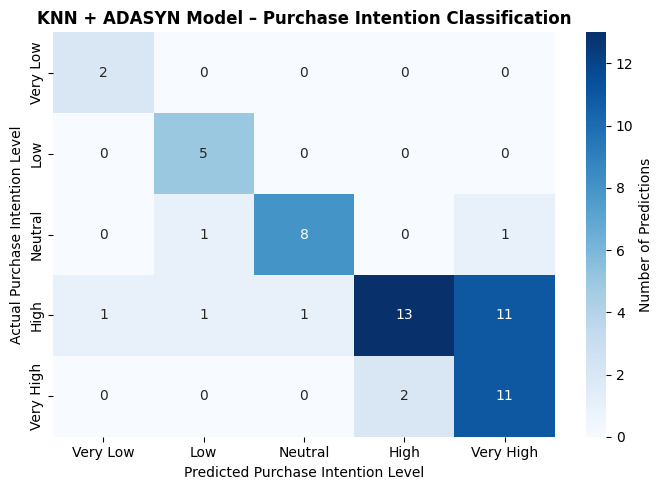

Accuracy (KNN + ADASYN): 0.68

Classification Report (KNN + ADASYN):

              precision    recall  f1-score   support

    Very Low       0.67      1.00      0.80         2
         Low       0.71      1.00      0.83         5
     Neutral       0.89      0.80      0.84        10
        High       0.87      0.48      0.62        27
   Very High       0.48      0.85      0.61        13

    accuracy                           0.68        57
   macro avg       0.72      0.83      0.74        57
weighted avg       0.76      0.68      0.68        57



In [ ]:
# Compute metrics
cm = confusion_matrix(y_true_knn_adasyn, y_pred_knn_adasyn)
accuracy = accuracy_score(y_true_knn_adasyn, y_pred_knn_adasyn)

# Define readable labels
labels = ['Very Low', 'Low', 'Neutral', 'High', 'Very High']

# Create heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'label': 'Number of Predictions'}
)

# Styling and layout
plt.title('KNN + ADASYN Model – Purchase Intention Classification', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Purchase Intention Level', fontsize=10)
plt.ylabel('Actual Purchase Intention Level', fontsize=10)
plt.tight_layout()
plt.show()

# Print accuracy and classification report
print(f"Accuracy (KNN + ADASYN): {accuracy:.2f}\n")
print("Classification Report (KNN + ADASYN):\n")
print(classification_report(y_true_knn_adasyn, y_pred_knn_adasyn, target_names=labels))


### Model fit

[bnlearn] >Parameter learning> Computing parameters using [bayes]


[bnlearn] >CPD of PV:
+--------+---------------------+-----+---------------------+
| C      | C(2)                | ... | C(5)                |
+--------+---------------------+-----+---------------------+
| CT_new | CT_new(1)           | ... | CT_new(5)           |
+--------+---------------------+-----+---------------------+
| PE     | PE(1)               | ... | PE(5)               |
+--------+---------------------+-----+---------------------+
| PPQ    | PPQ(1)              | ... | PPQ(5)              |
+--------+---------------------+-----+---------------------+
| PS     | PS(1)               | ... | PS(5)               |
+--------+---------------------+-----+---------------------+
| PV(1)  | 0.19999999999999998 | ... | 0.19999999999999998 |
+--------+---------------------+-----+---------------------+
| PV(2)  | 0.19999999999999998 | ... | 0.19999999999999998 |
+--------+---------------------+-----+---------------------+
| PV(3)  | 0.19999999999999998 | ... | 0.19999999999999998 |
+-


Summary for variables: ['PI']
Given evidence: E=2, C=4, PS=4, PPQ=4, PV=4, PE=3, CT_new=3, Gender=1, Marital Status=1, Age=1, Employment=2, Education=1, Type of Customer=1, Shopping Frequency=2

PI outcomes:
- PI: 1 (13.3%)
- PI: 2 (13.3%)
- PI: 3 (13.3%)
- PI: 4 (30.0%)
- PI: 5 (30.0%)
[bnlearn] >Variable Elimination.
+----+------+-----+
|    |   PI |   p |
+====+======+=====+
|  0 |    1 | 0.2 |
+----+------+-----+
|  1 |    2 | 0.2 |
+----+------+-----+
|  2 |    3 | 0.2 |
+----+------+-----+
|  3 |    4 | 0.2 |
+----+------+-----+
|  4 |    5 | 0.2 |
+----+------+-----+

Summary for variables: ['PI']
Given evidence: E=4, C=4, PS=2, PPQ=4, PV=4, PE=1, CT_new=4, Gender=1, Marital Status=2, Age=5, Employment=2, Education=1, Type of Customer=1, Shopping Frequency=2

PI outcomes:
- PI: 1 (20.0%)
- PI: 2 (20.0%)
- PI: 3 (20.0%)
- PI: 4 (20.0%)
- PI: 5 (20.0%)
[bnlearn] >Variable Elimination.
+----+------+-----+
|    |   PI |   p |
+====+======+=====+
|  0 |    1 | 0.2 |
+----+------+---

Streaming output truncated to the last 5000 lines.
PI outcomes:
- PI: 1 (4.4%)
- PI: 2 (76.7%)
- PI: 3 (10.0%)
- PI: 4 (4.4%)
- PI: 5 (4.4%)
[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.114286 |
+----+------+----------+
|  1 |    2 | 0.257143 |
+----+------+----------+
|  2 |    3 | 0.4      |
+----+------+----------+
|  3 |    4 | 0.114286 |
+----+------+----------+
|  4 |    5 | 0.114286 |
+----+------+----------+

Summary for variables: ['PI']
Given evidence: E=3, C=3, PS=2, PPQ=4, PV=2, PE=5, CT_new=4, Gender=1, Marital Status=1, Age=1, Employment=1, Education=2, Type of Customer=1, Shopping Frequency=2

PI outcomes:
- PI: 1 (11.4%)
- PI: 2 (25.7%)
- PI: 3 (40.0%)
- PI: 4 (11.4%)
- PI: 5 (11.4%)
[bnlearn] >Variable Elimination.
+----+------+------+
|    |   PI |    p |
+====+======+======+
|  0 |    1 | 0.79 |
+----+------+------+
|  1 |    2 | 0.09 |
+----+------+------+
|  2 |    3 | 0.04 |
+----+-----

Streaming output truncated to the last 5000 lines.
PI outcomes:
- PI: 1 (46.7%)
- PI: 2 (13.3%)
- PI: 3 (13.3%)
- PI: 4 (13.3%)
- PI: 5 (13.3%)
[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.466667 |
+----+------+----------+
|  1 |    2 | 0.133333 |
+----+------+----------+
|  2 |    3 | 0.133333 |
+----+------+----------+
|  3 |    4 | 0.133333 |
+----+------+----------+
|  4 |    5 | 0.133333 |
+----+------+----------+

Summary for variables: ['PI']
Given evidence: E=1, C=1, PS=1, PPQ=1, PV=1, PE=5, CT_new=5, Gender=1, Marital Status=3, Age=4, Employment=2, Education=4, Type of Customer=1, Shopping Frequency=1

PI outcomes:
- PI: 1 (46.7%)
- PI: 2 (13.3%)
- PI: 3 (13.3%)
- PI: 4 (13.3%)
- PI: 5 (13.3%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.0888889 |
+----+------+-----------+
|  1 |    2 | 0.2       |
+----+------+-------

Streaming output truncated to the last 5000 lines.
PI outcomes:
- PI: 1 (6.7%)
- PI: 2 (65.0%)
- PI: 3 (6.7%)
- PI: 4 (15.0%)
- PI: 5 (6.7%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.0888889 |
+----+------+-----------+
|  1 |    2 | 0.2       |
+----+------+-----------+
|  2 |    3 | 0.0888889 |
+----+------+-----------+
|  3 |    4 | 0.533333  |
+----+------+-----------+
|  4 |    5 | 0.0888889 |
+----+------+-----------+

Summary for variables: ['PI']
Given evidence: E=4, C=4, PS=2, PPQ=4, PV=3, PE=2, CT_new=3, Gender=1, Marital Status=1, Age=4, Employment=1, Education=3, Type of Customer=1, Shopping Frequency=1

PI outcomes:
- PI: 1 (8.9%)
- PI: 2 (20.0%)
- PI: 3 (8.9%)
- PI: 4 (53.3%)
- PI: 5 (8.9%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.0444444 |
+----+------+-----------+
|  1 |    2 | 0.0444444 |
+----+------+

Streaming output truncated to the last 5000 lines.
PI outcomes:
- PI: 1 (8.0%)
- PI: 2 (8.0%)
- PI: 3 (8.0%)
- PI: 4 (68.0%)
- PI: 5 (8.0%)
[bnlearn] >Variable Elimination.
+----+------+------+
|    |   PI |    p |
+====+======+======+
|  0 |    1 | 0.05 |
+----+------+------+
|  1 |    2 | 0.05 |
+----+------+------+
|  2 |    3 | 0.8  |
+----+------+------+
|  3 |    4 | 0.05 |
+----+------+------+
|  4 |    5 | 0.05 |
+----+------+------+

Summary for variables: ['PI']
Given evidence: E=3, C=4, PS=3, PPQ=2, PV=2, PE=4, CT_new=5, Gender=3, Marital Status=3, Age=5, Employment=1, Education=4, Type of Customer=1, Shopping Frequency=1

PI outcomes:
- PI: 1 (5.0%)
- PI: 2 (5.0%)
- PI: 3 (80.0%)
- PI: 4 (5.0%)
- PI: 5 (5.0%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.827778  |
+----+------+-----------+
|  1 |    2 | 0.105556  |
+----+------+-----------+
|  2 |    3 | 0.0222222 |
+----+------+-----------+
| 

Streaming output truncated to the last 5000 lines.
PI outcomes:
- PI: 1 (11.4%)
- PI: 2 (11.4%)
- PI: 3 (54.3%)
- PI: 4 (11.4%)
- PI: 5 (11.4%)
[bnlearn] >Variable Elimination.
+----+------+----------+
|    |   PI |        p |
+====+======+==========+
|  0 |    1 | 0.133333 |
+----+------+----------+
|  1 |    2 | 0.133333 |
+----+------+----------+
|  2 |    3 | 0.466667 |
+----+------+----------+
|  3 |    4 | 0.133333 |
+----+------+----------+
|  4 |    5 | 0.133333 |
+----+------+----------+

Summary for variables: ['PI']
Given evidence: E=3, C=4, PS=1, PPQ=2, PV=2, PE=4, CT_new=5, Gender=1, Marital Status=1, Age=4, Employment=2, Education=2, Type of Customer=1, Shopping Frequency=2

PI outcomes:
- PI: 1 (13.3%)
- PI: 2 (13.3%)
- PI: 3 (46.7%)
- PI: 4 (13.3%)
- PI: 5 (13.3%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.8       |
+----+------+-----------+
|  1 |    2 | 0.141463  |
+----+------+-------

Streaming output truncated to the last 5000 lines.

PI outcomes:
- PI: 1 (5.0%)
- PI: 2 (11.2%)
- PI: 3 (73.8%)
- PI: 4 (5.0%)
- PI: 5 (5.0%)
[bnlearn] >Variable Elimination.
+----+------+-------+
|    |   PI |     p |
+====+======+=======+
|  0 |    1 | 0.032 |
+----+------+-------+
|  1 |    2 | 0.032 |
+----+------+-------+
|  2 |    3 | 0.392 |
+----+------+-------+
|  3 |    4 | 0.232 |
+----+------+-------+
|  4 |    5 | 0.312 |
+----+------+-------+

Summary for variables: ['PI']
Given evidence: E=5, C=5, PS=3, PPQ=4, PV=3, PE=1, CT_new=3, Gender=1, Marital Status=1, Age=2, Employment=1, Education=2, Type of Customer=1, Shopping Frequency=1

PI outcomes:
- PI: 1 (3.2%)
- PI: 2 (3.2%)
- PI: 3 (39.2%)
- PI: 4 (23.2%)
- PI: 5 (31.2%)
[bnlearn] >Variable Elimination.
+----+------+-----------+
|    |   PI |         p |
+====+======+===========+
|  0 |    1 | 0.0421053 |
+----+------+-----------+
|  1 |    2 | 0.726316  |
+----+------+-----------+
|  2 |    3 | 0.0421053 |
+----+-----

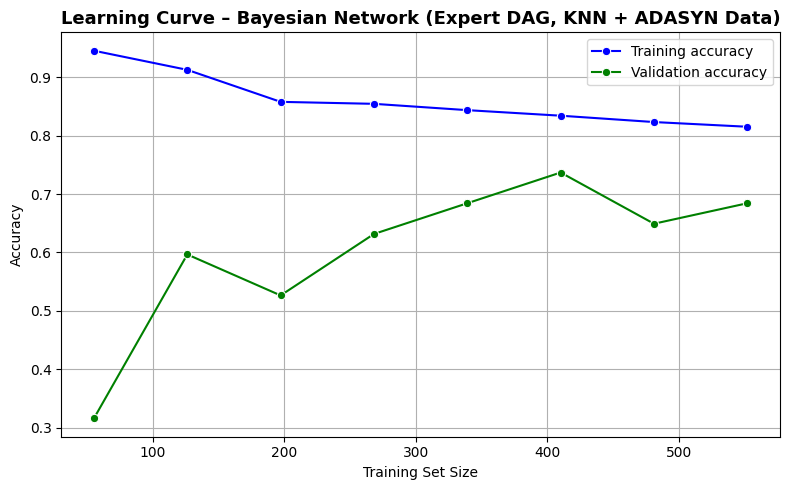

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Prepare training and validation datasets
train_knn_adasyn_shuffled = shuffle(train_balanced_knn_adasyn, random_state=42)
train_full = train_knn_adasyn_shuffled
valid_full = test_data  # untouched real test set

# Define training fractions
train_sizes = np.linspace(0.1, 1.0, 8)

train_accuracies = []
valid_accuracies = []

# Learning curve loop
for frac in train_sizes:
    subset_size = int(frac * len(train_full))
    subset = train_full.iloc[:subset_size]

    # Fit BN on subset
    fitted_subset = bn.parameter_learning.fit(
        bn_model_knn_adasyn,
        subset,
        methodtype='bayes',
        n_jobs=-1
    )

    # Training accuracy
    y_train_true = subset["PI"].tolist()
    y_train_pred = []

    for _, row in subset.iterrows():
        raw_ev = row.drop("PI").to_dict()
        raw_ev = {k: v for k, v in raw_ev.items() if pd.notna(v)}
        evidence_knn = normalize_evidence(raw_ev, fitted_subset)

        try:
            q = bn.inference.fit(fitted_subset, variables=["PI"], evidence=evidence_knn)
            pred = q.df.loc[q.df["p"].idxmax(), "PI"]
            pred = int(pred) if not isinstance(pred, (int, np.integer)) else pred
        except Exception:
            pred = np.nan

        y_train_pred.append(pred)

    mask = ~pd.isna(y_train_pred)
    train_acc = accuracy_score(np.array(y_train_true)[mask], np.array(y_train_pred)[mask]) if np.sum(mask) > 0 else np.nan
    train_accuracies.append(train_acc)

    # Validation accuracy
    y_valid_true = valid_full["PI"].tolist()
    y_valid_pred = []

    for _, row in valid_full.iterrows():
        raw_ev = row.drop("PI").to_dict()
        raw_ev = {k: v for k, v in raw_ev.items() if pd.notna(v)}
        evidence_knn = normalize_evidence(raw_ev, fitted_subset)

        try:
            q = bn.inference.fit(fitted_subset, variables=["PI"], evidence=evidence_knn)
            pred = q.df.loc[q.df["p"].idxmax(), "PI"]
            pred = int(pred) if not isinstance(pred, (int, np.integer)) else pred
        except Exception:
            pred = np.nan

        y_valid_pred.append(pred)

    mask = ~pd.isna(y_valid_pred)
    valid_acc = accuracy_score(np.array(y_valid_true)[mask], np.array(y_valid_pred)[mask]) if np.sum(mask) > 0 else np.nan
    valid_accuracies.append(valid_acc)

    print(f"Training fraction {frac:.2f} | Train Acc: {train_acc:.3f} | Val Acc: {valid_acc:.3f}")

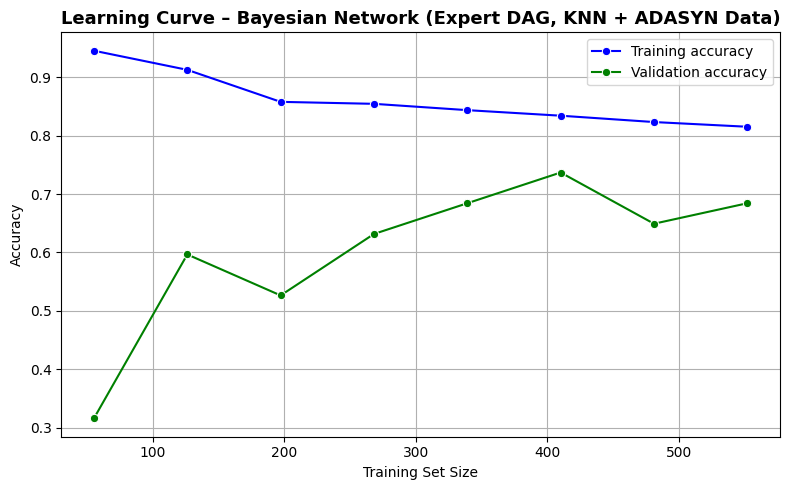

In [ ]:
# Plot learning curve
plt.figure(figsize=(8, 5))
sns.lineplot(x=train_sizes * len(train_full), y=train_accuracies, marker='o', label='Training accuracy', color='blue')
sns.lineplot(x=train_sizes * len(train_full), y=valid_accuracies, marker='o', label='Validation accuracy', color='green')
plt.title("Learning Curve – Bayesian Network (Expert DAG, KNN + ADASYN Data)", fontsize=13, fontweight='bold')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Textual Fit Evaluation
def evaluate_fit(train_accs, val_accs, threshold_gap=0.05):
    final_train = train_accs[-1]
    final_val = val_accs[-1]
    gap = final_train - final_val

    print("\n--- Fit Evaluation ---")
    print(f"Final Training Accuracy : {final_train:.4f}")
    print(f"Final Validation Accuracy : {final_val:.4f}")
    print(f"Train–Validation Gap : {gap:.4f}")

    dynamic_threshold = 0.9 * final_train

    if final_train < 0.65 and final_val < 0.65:
        print("⚙️  Model is **underfitting** – accuracies are both low, model too simple or data insufficient.")
    elif gap > threshold_gap:
        print("⚠️  Model is **overfitting** – training accuracy is high, validation accuracy is lagging.")
    elif final_val >= dynamic_threshold:
        print("✅  Model is **well-fitted** – validation accuracy is close to training accuracy, good generalisation.")
    else:
        print("ℹ️  Model is **moderately fitted** – acceptable but may improve with more data or DAG refinement.")

# Run fit evaluation
evaluate_fit(train_accuracies, valid_accuracies)


--- Fit Evaluation ---
Final Training Accuracy : 0.8152
Final Validation Accuracy : 0.6842
Train–Validation Gap : 0.1310
⚠️  Model is **overfitting** – training accuracy is high, validation accuracy is lagging.


While this approach can improve the performance of discriminative classifiers, it often introduces noisy or borderline synthetic cases that reduce the clarity of class boundaries. In Bayesian Networks, this results in inconsistent conditional dependencies, as the model is forced to learn from atypical or contradictory feature combinations, ultimately reducing its ability to capture true probabilistic structures.

While this approach can improve the performance of discriminative classifiers, it often introduces noisy or borderline synthetic cases that reduce the clarity of class boundaries. In the current study, the Bayesian Network trained on the ADASYN-balanced data achieved a training accuracy of 0.8152 and a validation accuracy of 0.6842, producing a train–validation gap of 0.1310, which indicates clear overfitting. This suggests that although the model fitted the synthetic training data relatively well, it struggled to generalise to the unseen test data. In Bayesian Networks, this behaviour results from inconsistent conditional dependencies, as the model is forced to learn from atypical or contradictory feature combinations generated by ADASYN, ultimately reducing its ability to capture true probabilistic structures.

It begins by separating the training data into features and the target variable (PI). Although a KNN model is briefly trained on the imbalanced data, this step is not directly used in the Bayesian Network; its real influence comes through ADASYN. ADASYN uses a KNN-based approach to identify which minority samples are harder to classify — specifically, it looks at the neighbourhood around each minority point, and if most of its neighbours are majority-class points, it generates more synthetic samples in that region. This results in a balanced training dataset where the minority classes are better represented, particularly in difficult areas of the feature space. The Bayesian Network is then trained on this balanced dataset using the fixed expert DAG structure, which updates the conditional probabilities to reflect the improved class distribution. Finally, the model is tested on the original test data: evidence is prepared from each row, adjusted to match the BN’s expected state types, and used to predict PI. These predictions are compared with the true values, and performance is reported through accuracy, a confusion matrix, and a classification report.

# Model comparison and evaluation

In [ ]:
import pandas as pd


results = [
    {
        "Model": "Original (Unbalanced)",
        "Accuracy": 0.77,
        "Macro Precision": 0.76,
        "Macro Recall": 0.78,
        "Macro F1": 0.77,
        "Final Train Acc": 0.79,
        "Final Val Acc": 0.77,
        "Train–Val Gap": 0.79 - 0.77,
        "Fit Assessment": "Well-fitted"
    },
    {
        "Model": "SMOTE (Tabular Oversampling)",
        "Accuracy": 0.72,
        "Macro Precision": 0.75,
        "Macro Recall": 0.84,
        "Macro F1": 0.77,
        "Final Train Acc": 0.85,
        "Final Val Acc": 0.72,
        "Train–Val Gap": 0.85 - 0.72,
        "Fit Assessment": "Overfitting"
    },
    {
        "Model": "CTGAN (Synthetic Data)",
        "Accuracy": 0.68,
        "Macro Precision": 0.69,
        "Macro Recall": 0.69,
        "Macro F1": 0.71,
        "Final Train Acc": 0.59,
        "Final Val Acc": 0.68,
        "Train–Val Gap": 0.59 - 0.68,
        "Fit Assessment": "Well-fitted"
    },
    {
        "Model": "KNN + ADASYN (ML Balancing)",
        "Accuracy": 0.68,
        "Macro Precision": 0.72,
        "Macro Recall": 0.83,
        "Macro F1": 0.74,
        "Final Train Acc": 0.82,
        "Final Val Acc": 0.68,
        "Train–Val Gap": 0.82 - 0.68,
        "Fit Assessment": "Overfitting"
    }
]

# Create DataFrame and sort by accuracy (descending)
df_models = pd.DataFrame(results)
df_models = df_models.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

# Display
df_models


Model  Accuracy  Macro Precision  Macro Recall  \
0         Original (Unbalanced)      0.77             0.76          0.78   
1  SMOTE (Tabular Oversampling)      0.72             0.75          0.84   
2        CTGAN (Synthetic Data)      0.68             0.69          0.69   
3   KNN + ADASYN (ML Balancing)      0.68             0.72          0.83   

   Macro F1  Final Train Acc  Final Val Acc  Train–Val Gap Fit Assessment  
0      0.77             0.79           0.77           0.02    Well-fitted  
1      0.77             0.85           0.72           0.13    Overfitting  
2      0.71             0.59           0.68          -0.09    Well-fitted  
3      0.74             0.82           0.68           0.14    Overfitting

## 1. Baseline: Original Dataset (No Balancing)

The unbalanced data produced the strongest overall performance. The expert-structured Bayesian Network achieved an accuracy of 0.77, which was the highest among all models. Macro-averaged precision (0.76), recall (0.78), and F1-score (0.77) indicate balanced predictive behaviour across classes despite the inherent class imbalance.

The learning curve shows that training and validation accuracy converge closely (train = 0.79; validation = 0.77), and the train–validation gap is minimal (0.02). The model is therefore assessed as well-fitted, with no indication of overfitting or instability. This establishes a reliable baseline for comparison.



## 2. SMOTE Balancing

Applying SMOTE increased the representation of minority classes, yielding improvements in minority-class recall. The macro-recall increased to 0.84, particularly enhancing the correct identification of “Very Low” and “Low” purchase-intention levels.

However, overall accuracy decreased to 0.72, and some precision values declined—indicating a higher rate of false positives for the “High” and “Very High” categories. The learning curve shows a noticeable gap between training (0.85) and validation (0.72) accuracy. According to the model-fit assessment, SMOTE caused the Bayesian Network to overfit: the model learns the synthetic patterns well but generalises less effectively to unseen data.

SMOTE therefore provides better sensitivity to minority classes but at the cost of overall model reliability.

## 3. CTGAN Balancing

CTGAN generated an expanded synthetic dataset using generative modelling. However, classification performance declined compared to both the baseline and SMOTE. Overall accuracy dropped to 0.68, with macro-precision (0.65) and macro-F1 (0.71) notably lower than the unbalanced model. Minority-class F1-scores remained unstable due to inconsistent GAN sampling.

The learning curve shows relatively close alignment between training (0.59) and validation accuracy (0.68), and the model was classified as well-fitted with no overfitting. Despite its regularisation benefits, CTGAN does not provide improved predictive performance in this application. The synthetic distribution appears insufficiently representative of real purchasing patterns, reducing classification effectiveness.

## 4. KNN + ADASYN Balancing

The KNN+ADASYN hybrid approach produced results similar to CTGAN. Accuracy remained at 0.68, and although macro recall improved (0.83), precision and F1-scores declined relative to SMOTE and the baseline model.

The learning curve shows large separations between training (0.82) and validation (0.68) accuracy, and the model-fit evaluation categorised this method as overfitting. ADASYN’s tendency to generate synthetic minority samples near class boundaries likely contributes to noisy decision regions, weakening generalisation.

# Conclusion

The results of the analysis supported both hypotheses. Balancing the dataset reduced the overall predictive accuracy of the Bayesian Network, confirming that the high accuracy of the original model was partly driven by majority-class dominance rather than genuine predictive power. However, balancing the data substantially improved minority-class fairness and representativeness, allowing the Bayesian Network to provide more meaningful and equitable predictions across all purchase-intention categories. Although accuracy declined, the balanced models offered clearer inference patterns, reduced bias, and a more reliable depiction of consumer behaviour, demonstrating that data balancing enhances the interpretive value of Bayesian Network outputs even when overall accuracy decreases.